# Exploration Amazon Notebook
Amazon Prime is another one of the most popular media and video streaming platforms. They have close to 10000 movies or tv shows available on their platform, as of mid-2021, they have over 200M Subscribers globally.

This tabular dataset consists of listings of all the movies and tv shows available on Amazon Prime, along with details such as - cast, directors, ratings, release year, duration, etc.

As a data scientist working for Amazon Prime Video, your task is to improve the platform's recommendation system to enhance user engagement and satisfaction. With the wealth of data available, you aim to develop a personalized recommendation algorithm that suggests movies and TV shows tailored to each user's preferences.

In [1]:
#For data handling
import pandas as pd
import numpy as np

#For visualization
import matplotlib.pyplot as plt
import seaborn as sns

#For handling categorical and missing data
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder, MultiLabelBinarizer

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

from sklearn.metrics.pairwise import cosine_similarity

#Creating the train test split
from sklearn.model_selection import train_test_split
import re

# Importing library
from scipy.stats import skew, kurtosis

sns.set_style('darkgrid')

## Note about the following two cells:

We will need the following two cells to run some LLM related content towards the end of the notebook. For the majority of the notebook, if you would like to skip these next two cells for installs and follow along on a CPU that is perfectly fine. When we do the LLM portion, you can either watch me or connect to a GPU on Colab or Kaggle.

In [2]:
!pip install -U sentence-transformers umap-learn hdbscan bertopic

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.3/163.3 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 66.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.1/154.1 kB 23.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 9.4 MB/s eta 0:00:00
  Using cached Cython-0.29.37-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_24_x86_64.whl (1.9 MB)
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (7

In [7]:
from umap import UMAP
from hdbscan import HDBSCAN
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer

from bertopic import BERTopic
from bertopic.vectorizers import ClassTfidfTransformer

# Pull in data
Look at the initial records of the data and perform elementary EDA.

In [8]:
# read in the data via read_csv
df = pd.read_csv('sample_data/amazon_prime_titles.csv')

In [10]:
# view the top 5 rows of the data
df.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,The Grand Seduction,Don McKellar,"Brendan Gleeson, Taylor Kitsch, Gordon Pinsent",Canada,"March 30, 2021",2014,NaN,113 min,"Comedy, Drama",A small fishing village must procure a local d...
1,s2,Movie,Take Care Good Night,Girish Joshi,"Mahesh Manjrekar, Abhay Mahajan, Sachin Khedekar",India,"March 30, 2021",2018,13+,110 min,"Drama, International",A Metro Family decides to fight a Cyber Crimin...
2,s3,Movie,Secrets of Deception,Josh Webber,"Tom Sizemore, Lorenzo Lamas, Robert LaSardo, R...",United States,"March 30, 2021",2017,NaN,74 min,"Action, Drama, Suspense",After a man discovers his wife is cheating on ...
3,s4,Movie,Pink: Staying True,Sonia Anderson,"Interviews with: Pink, Adele, Beyoncé, Britney...",United States,"March 30, 2021",2014,NaN,69 min,Documentary,"Pink breaks the mold once again, bringing her ..."
4,s5,Movie,Monster Maker,Giles Foster,"Harry Dean Stanton, Kieran O'Brien, George Cos...",United Kingdom,"March 30, 2021",1989,NaN,45 min,"Drama, Fantasy",Teenage Matt Banting wants to work with a famo...


In [11]:
# view the dimensions of the data using df.shape
df.shape

(9668, 12)

In [12]:
# look at data types as well as missing values in the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9668 entries, 0 to 9667
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       9668 non-null   object
 1   type          9668 non-null   object
 2   title         9668 non-null   object
 3   director      7585 non-null   object
 4   cast          8435 non-null   object
 5   country       672 non-null    object
 6   date_added    155 non-null    object
 7   release_year  9668 non-null   int64 
 8   rating        9331 non-null   object
 9   duration      9668 non-null   object
 10  listed_in     9668 non-null   object
 11  description   9668 non-null   object
dtypes: int64(1), object(11)
memory usage: 906.5+ KB


Notice that there is a lot of missing values in various columns. Let's go ahead and impute them (i.e., deal with them by filling). Percentage wise how much does each feature have in null values.

In [13]:
# get a percentage of missing values in each column
# round each missing percentage two decimal units
df['date_added'].isna().sum()/len(df)

np.round(df.isna().sum()/len(df), 4) * 100

show_id          0.00
type             0.00
title            0.00
director        21.55
cast            12.75
country         93.05
date_added      98.40
release_year     0.00
rating           3.49
duration         0.00
listed_in        0.00
description      0.00
dtype: float64

Given that the `director`, `cast`, `data_added`, and `rating` are null and there's no real way of finding them with the given data, let's just impute them with `Unknown`.

This command is often forgotten, so let's ask Google Colab's AI assistant to help with this. Ask it something like: `fill in null values of director, cast, data_added, and rating in the data frame`

In [14]:
# prompt: fill in null values of director, cast, data_added, and rating in the data frame

df[['director', 'cast', 'date_added', 'rating']] = df[['director', 'cast', 'date_added', 'rating']].fillna('Unknown')


In [ ]:
# fill in director, date_added, cast, rating column with 'Unknown' value for nulls
# prompt: how to fill null values of a column in a pandas dataframe


Looking at the `country` column, most movies and shows are mostly null and they are predominately made in the US (just from observation) so we are going to fill the nulls in with the most frequent value.

Let's ask Google's assistant again. Ask is something like this: `impute missing values of a country column using sklearn SimpleImputer`

In [19]:
# prompt: impute missing values of a country column using sklearn SimpleImputer

from sklearn.impute import SimpleImputer

imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')

df['country'] = imputer.fit_transform(df['country'].values.reshape(-1, 1)).reshape(-1)


In [ ]:
# use an imputer to fill in all the missing values
# easier ways to do this, but this is good to get
# practice with especially with productionization.


Check to make sure that there are no more null features.

In [20]:
# use the same code as before
np.round(df.isna().sum()/len(df), 4) * 100

show_id         0.0
type            0.0
title           0.0
director        0.0
cast            0.0
country         0.0
date_added      0.0
release_year    0.0
rating          0.0
duration        0.0
listed_in       0.0
description     0.0
dtype: float64

In [21]:
# look at a few different examples.
df.sample(7)

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
6673,s6674,Movie,Standby,"Rob Burke, Ronan Burke","Jessica Paré, Brian Gleeson",United States,Unknown,2015,NR,83 min,Comedy,"In an Irish airport, a woman waiting standby (..."
7902,s7903,Movie,The Speed Reporter 1936 Crime Drama Thriller F...,Bernard Ray,"Richard Talmadge, Luana Walters",United States,Unknown,1936,16+,51 min,"Drama, Romance",After a night of gangster terrorism in a large...
88,s89,Movie,Winterset,Alfred Santell,"Burgess Meredith, Eduordo Ciannelli",United States,Unknown,1936,NR,77 min,"Action, Drama",Immigrant radical Bartolomeo Romagna is falsel...
632,s633,Movie,The Great War,Steven Luke,"Ron Perlman, Billy Zane, Bates Wilder, Hiram A...",United States,Unknown,2019,R,110 min,"Action, Drama","During the last days of the Great War, Lt. Wil..."
7987,s7988,Movie,The Scarlet Pirate,Jon Silver,"Vijay Sarathi, Bri Fitzpatrick, Clayton Marges...",United States,Unknown,2020,16+,75 min,Comedy,"A very silly, ultra-low budget pirate romp, la..."
7638,s7639,Movie,Clown Motel Vacancies,Jason Mills,"Kiana Passmore, Darren Andrichuck, Scott Osbor...",United States,Unknown,2018,18+,71 min,"Horror, Suspense","When Shane has unfinished business, both perso..."
7842,s7843,TV Show,My Magic Pet Morphle - Songs for Kids,Unknown,Unknown,United States,Unknown,2021,ALL,1 Season,Kids,Morphle can morph into anything his human comp...


We notice that the dataset contains TV Shows and Movies, let's see the distribution of each kind. Also, is there a relationship between the type and directors.

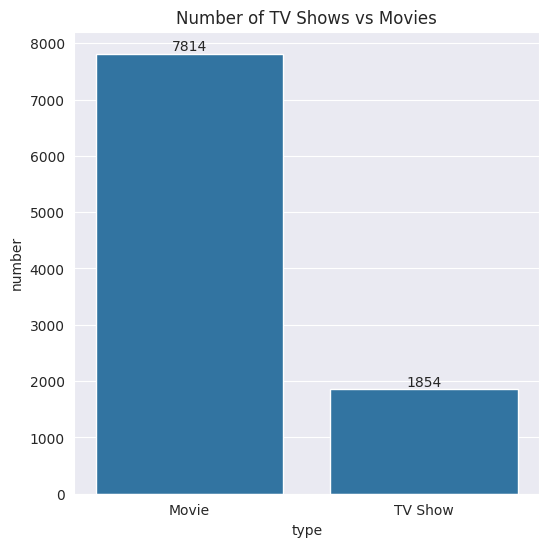

In [22]:
# see that there are movies and tv shows
movie_tv = df.type.value_counts(normalize=False)\
                  .rename('number')\
                  .to_frame()\
                  .reset_index()\
                  .rename(columns={'index':'type'})

plt.figure(figsize=(6, 6))
ax = sns.barplot(movie_tv, x='type', y='number')
plt.title('Number of TV Shows vs Movies')
ax.bar_label(ax.containers[0])
plt.plot();

In [24]:
# get the top 15 directors by count - use the value counts method

#### Type Code Here ####
df['director'].value_counts().head(15)

director
Unknown                  2083
Mark Knight               113
Cannis Holder              61
Moonbug Entertainment      37
Jay Chapman                34
Arthur van Merwijk         30
Manny Rodriguez            22
John English               20
1                          16
Brian Volk-Weiss           15
Baeble Music               14
Joseph Kane                13
George Archainbaud         12
Michael J. Nelson          12
Aaron Michael              11
Name: count, dtype: int64

In [26]:
# there are a good amount of unknown directors so
# find out if the unknown directors
# correspond to movies or tv shows more
# what do you notice?

#### Type Code Here ####
df[df.director == 'Unknown'].type.value_counts(normalize=True)

type
TV Show    0.890062
Movie      0.109938
Name: proportion, dtype: float64

In [27]:
# what do you notice about the
# directors for all tv shows in the
# data frame

#### Type Code Here ####
df[df.type == 'TV Show'].director.value_counts(normalize=True)

director
Unknown    1.0
Name: proportion, dtype: float64

# Ratings Exploration
Let's look at the distribution of ratings in the dataset and see if there are any correlations between ratings and type.

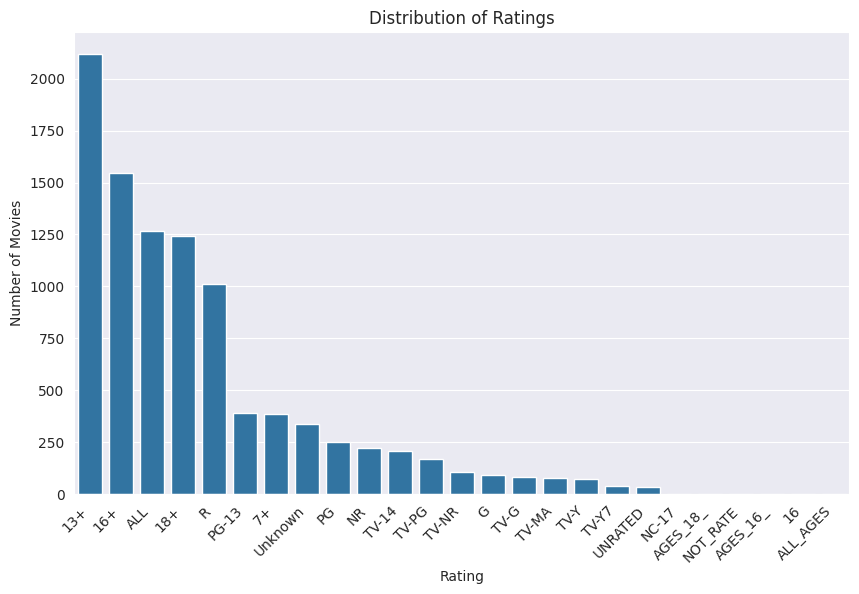

In [28]:
# plot a distribution of ratings amoung all
# movies and tv shows
plt.figure(figsize=(10, 6))
sns.countplot(x='rating', data=df, order=df['rating'].value_counts().index)
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Number of Movies')
plt.xticks(rotation=45, ha='right')
plt.show()

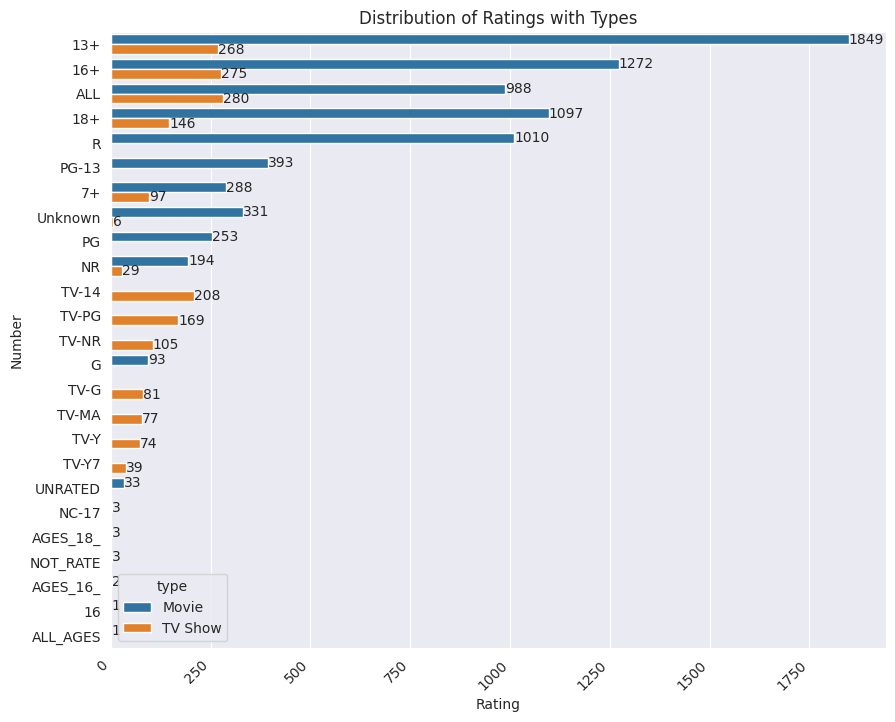

In [29]:
# Distribution of ratings and correlation to type
plt.figure(figsize=(10, 8))
ax = sns.countplot(y='rating',
                   data=df,
                   order=df['rating'].value_counts().index,
                   hue='type')
plt.title('Distribution of Ratings with Types')
plt.xlabel('Rating')
plt.ylabel('Number')
plt.xticks(rotation=45, ha='right')
ax.bar_label(ax.containers[0])
ax.bar_label(ax.containers[1])
plt.show()

# Listings Exploration
Let's take a deeper dive into the `listed_in` feature and notice if we see anything. This is also commonly known as the genres of the tv shows and movies. Let's take a deeper dive into this.

In [30]:
# get the number of unique values inside
# of the listed_in feature

#### Type Code Here ####
df['listed_in'].nunique()

518

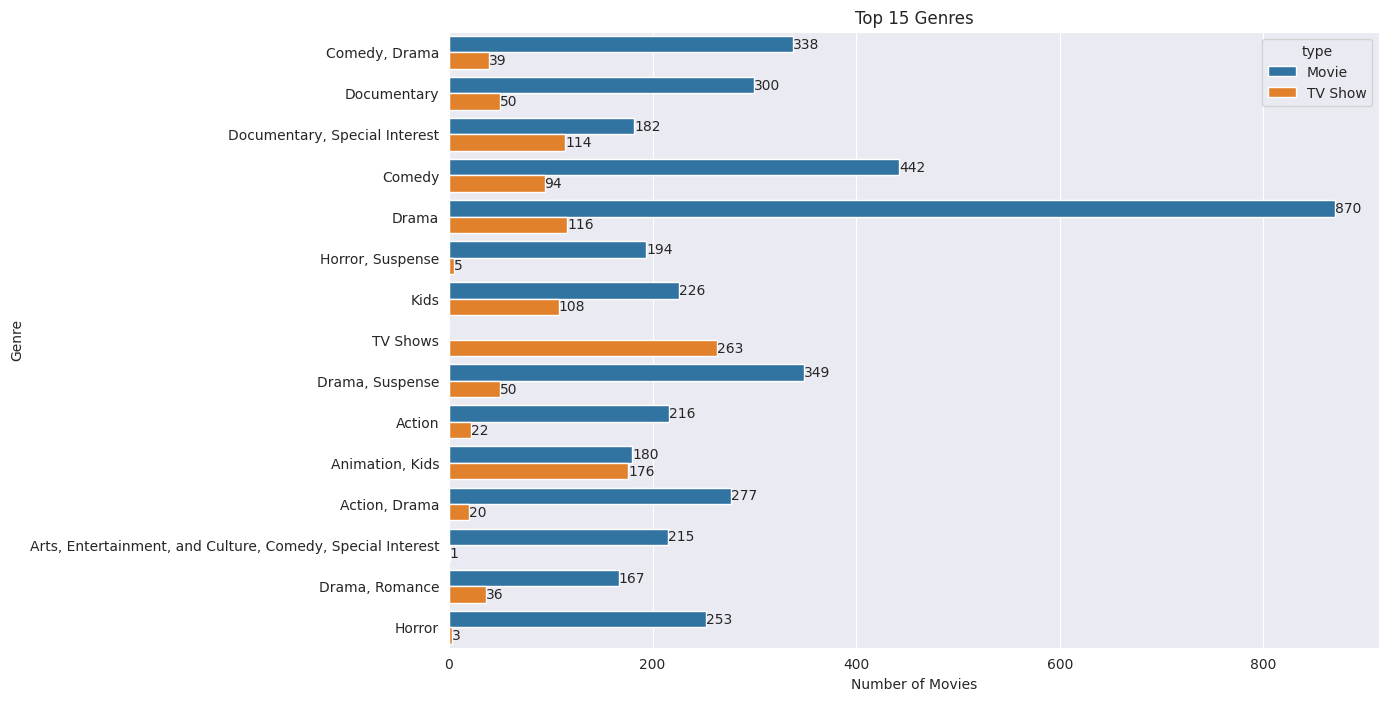

In [31]:
# plot the top genres
top_genres = df['listed_in'].value_counts().head(15).index.tolist()

# get all records that correspond to the top genres
top_genre_df = df[df.listed_in.isin(top_genres)]
# Plot Top Genres
plt.figure(figsize=(12, 8))
ax = sns.countplot(data = top_genre_df, y='listed_in', hue='type')
plt.title('Top 15 Genres')
plt.xlabel('Number of Movies')
plt.ylabel('Genre')
ax.bar_label(ax.containers[0])
ax.bar_label(ax.containers[1])
plt.show()

Notice that there is some overlap in the genres. For example, `comedy` is in `comedy` as well as  `comedy, drama`. Let's see if we can separate the features from each other and just to a plain count of how often the individual genres occur.

In [34]:
'Horror, Suspense'.split(',')

['Horror', ' Suspense']

In [32]:
# really long genre related to Arts, Entertainment, and Culture, let's make it
# one genre by replacing where the comma is.
df['listed_in'] = df.listed_in.apply(lambda x : re.sub('Arts, Entertainment, and Culture', 'Arts Entertainment and Culture', x)
                                                if re.search('Arts, Entertainment, and Culture', x) else x)

In [35]:
# split the listed_in features and get a list
# inside a new feature called 'genres'
df['genres'] = df['listed_in'].apply(lambda x : [z.strip(' ') for z in x.split(',')])

df.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,genres
0,s1,Movie,The Grand Seduction,Don McKellar,"Brendan Gleeson, Taylor Kitsch, Gordon Pinsent",Canada,"March 30, 2021",2014,Unknown,113 min,"Comedy, Drama",A small fishing village must procure a local d...,"[Comedy, Drama]"
1,s2,Movie,Take Care Good Night,Girish Joshi,"Mahesh Manjrekar, Abhay Mahajan, Sachin Khedekar",India,"March 30, 2021",2018,13+,110 min,"Drama, International",A Metro Family decides to fight a Cyber Crimin...,"[Drama, International]"
2,s3,Movie,Secrets of Deception,Josh Webber,"Tom Sizemore, Lorenzo Lamas, Robert LaSardo, R...",United States,"March 30, 2021",2017,Unknown,74 min,"Action, Drama, Suspense",After a man discovers his wife is cheating on ...,"[Action, Drama, Suspense]"
3,s4,Movie,Pink: Staying True,Sonia Anderson,"Interviews with: Pink, Adele, Beyoncé, Britney...",United States,"March 30, 2021",2014,Unknown,69 min,Documentary,"Pink breaks the mold once again, bringing her ...",[Documentary]
4,s5,Movie,Monster Maker,Giles Foster,"Harry Dean Stanton, Kieran O'Brien, George Cos...",United Kingdom,"March 30, 2021",1989,Unknown,45 min,"Drama, Fantasy",Teenage Matt Banting wants to work with a famo...,"[Drama, Fantasy]"


If we want to find out how often a certain genre appears across all movies (for example, how often does just `comedy` appear), we need to one hot encode the `listed_in` feature. That can be tricky to do if we have lists. This is where MultiLabelBinarizer comes into the picture and does the OHE for us! For more information on MultilabelBinarizer see [this](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MultiLabelBinarizer.html).

In [36]:
# use the MultilabelBinarizer to one hot encode features
# this will give you an array of genres

# create a MultiLabelBinarizer object
mlb = MultiLabelBinarizer()

# fit_transform the MultilabelBinarizer on the
# newly found genres column.
mlb.fit_transform(df['genres'])

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0]])

In [37]:
# look at the classes that the multilabel binarizer found
# these are the genres that have been listed inside the dataset.
mlb.classes_

array(['Action', 'Adventure', 'Animation', 'Anime', 'Arthouse',
       'Arts Entertainment and Culture', 'Comedy', 'Documentary', 'Drama',
       'Faith and Spirituality', 'Fantasy', 'Fitness', 'Historical',
       'Horror', 'International', 'Kids', 'LGBTQ', 'Military and War',
       'Music Videos and Concerts', 'Romance', 'Science Fiction',
       'Special Interest', 'Sports', 'Suspense', 'TV Shows',
       'Talk Show and Variety', 'Unscripted', 'Western',
       'Young Adult Audience'], dtype=object)

In [38]:
# create a data frame with the rows as listed_in
# and the columns the new found individual dramas.
pd.set_option('display.max_columns', None)

df_mlb = pd.DataFrame(mlb.fit_transform(df['genres']), columns=mlb.classes_, index=df.index)

df_genre = pd.concat([df[['title', 'type', 'listed_in', 'genres']], df_mlb], axis=1)

df_genre.head()

,title,type,listed_in,genres,Action,Adventure,Animation,Anime,Arthouse,Arts Entertainment and Culture,Comedy,Documentary,Drama,Faith and Spirituality,Fantasy,Fitness,Historical,Horror,International,Kids,LGBTQ,Military and War,Music Videos and Concerts,Romance,Science Fiction,Special Interest,Sports,Suspense,TV Shows,Talk Show and Variety,Unscripted,Western,Young Adult Audience
0,The Grand Seduction,Movie,"Comedy, Drama","[Comedy, Drama]",0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Take Care Good Night,Movie,"Drama, International","[Drama, International]",0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Secrets of Deception,Movie,"Action, Drama, Suspense","[Action, Drama, Suspense]",1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3,Pink: Staying True,Movie,Documentary,[Documentary],0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Monster Maker,Movie,"Drama, Fantasy","[Drama, Fantasy]",0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [39]:
# see how often each genre occured across the TV shows and Movies.

# TV Shows
df_genre[df_genre.type == 'TV Show'].iloc[:, 4:]\
                                    .sum(axis=0)\
                                    .sort_values(ascending=False)\
                                    .head(15)

Drama               481
Kids                406
Documentary         314
Comedy              278
Special Interest    273
Animation           268
TV Shows            263
Action              155
Unscripted          151
Suspense            120
Romance              82
International        71
Science Fiction      58
Sports               54
Anime                51
dtype: int64

In [40]:
# Movies
df_genre[df_genre.type == 'Movie'].iloc[:, 4:]\
                                  .sum(axis=0)\
                                  .sort_values(ascending=False)\
                                  .head(15)

Drama                             3206
Comedy                            1821
Action                            1502
Suspense                          1381
Horror                             845
Special Interest                   707
Kids                               679
Documentary                        679
Romance                            592
Arts Entertainment and Culture     444
Science Fiction                    399
International                      284
Animation                          279
Adventure                          230
Western                            224
dtype: int64

# Duration Exploration
Do some exploration on the duration. The duration of the movies and TV shows can vary depending on type of movie, genre etc. Let's do some exploration there to see if there is anything to discover.

In [41]:
# get all of the unique values
# inside of the duration feature
# what do you notice

#### Type Code Here ####
df.duration.unique()

array(['113 min', '110 min', '74 min', '69 min', '45 min', '52 min',
       '98 min', '131 min', '87 min', '92 min', '88 min', '93 min',
       '94 min', '46 min', '96 min', '1 Season', '104 min', '62 min',
       '50 min', '3 Seasons', '2 Seasons', '86 min', '36 min', '37 min',
       '103 min', '9 min', '18 min', '14 min', '20 min', '19 min',
       '22 min', '60 min', '6 min', '54 min', '5 min', '84 min',
       '126 min', '125 min', '109 min', '89 min', '85 min', '56 min',
       '40 min', '111 min', '33 min', '34 min', '95 min', '99 min',
       '78 min', '4 Seasons', '77 min', '55 min', '53 min', '115 min',
       '58 min', '49 min', '135 min', '91 min', '64 min', '59 min',
       '48 min', '122 min', '90 min', '102 min', '65 min', '114 min',
       '136 min', '70 min', '138 min', '100 min', '480 min', '4 min',
       '30 min', '152 min', '68 min', '57 min', '7 Seasons', '31 min',
       '151 min', '149 min', '9 Seasons', '141 min', '121 min', '79 min',
       '140 min', '51 min'

In [42]:
# create a new feature called 'duration_season'
# where we indicate if the duration
# feature has 'season' in the title or not.
# maybe there is some correlation there between that and TV shows
# use the regex library from python
df['duration_season'] = df.duration.apply(lambda x : True if re.search('season', x.lower()) else False)

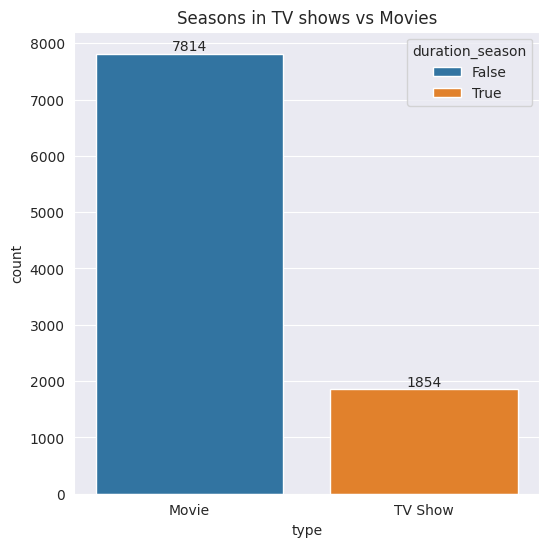

In [43]:
# plot the movies vs tv shows and see how many of them have
# seasons in the duration title.
# what do you notice?
plt.figure(figsize=(6, 6))
ax=sns.countplot(df, x='type', hue='duration_season')
plt.title('Seasons in TV shows vs Movies')
ax.bar_label(ax.containers[0])
ax.bar_label(ax.containers[1])
plt.plot();

So all TV Shows are measured in seasons rather than minutes, which makes sense. Let's clean this data up and see if we can view any correlations between duration and genre type

## Movie Duration Exploration
Let's do movies first and see if we can find some interesting insights within the movies in terms of duration time.

In [45]:
'10 min'.split('min')[0]

'10 '

In [46]:
# get all of the movies based off of our new feature (we could also use the type feature)
df_movies = df[df.duration_season==False].copy()

# create a new feature which strips the 'min' from the feature value
# and gets a numerical value for the length of the movie. Call this 'duration_time'.
df_movies['duration_time'] = df_movies.duration.apply(lambda x : x.split('min')[0]).astype(int)
df_movies.sample(3)

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,genres,duration_season,duration_time
8504,s8505,Movie,Yakuza Apocalypse,Takashi Miike,"Hayato Ichihara, Riko Narumi, Lily Franky, Yay...","Japan, France",Unknown,2015,18+,115 min,"Action, Horror","In 'Yakuza Apocalypse', fearsome Yakuza boss K...","[Action, Horror]",False,115
3056,s3057,Movie,Black Lives Matter,Nirit Peled,Unknown,United States,Unknown,2017,18+,48 min,"Documentary, Special Interest","In 2013 in Sanford, Florida, vigilante George ...","[Documentary, Special Interest]",False,48
6427,s6428,Movie,Chu Liuxiang: The Beginning,Wei Dong,"Pinchao Guo, Kang Ning",United States,Unknown,2021,18+,78 min,"Action, Drama",Liuxiang Chu (Pinchao Guo) who aims to become ...,"[Action, Drama]",False,78


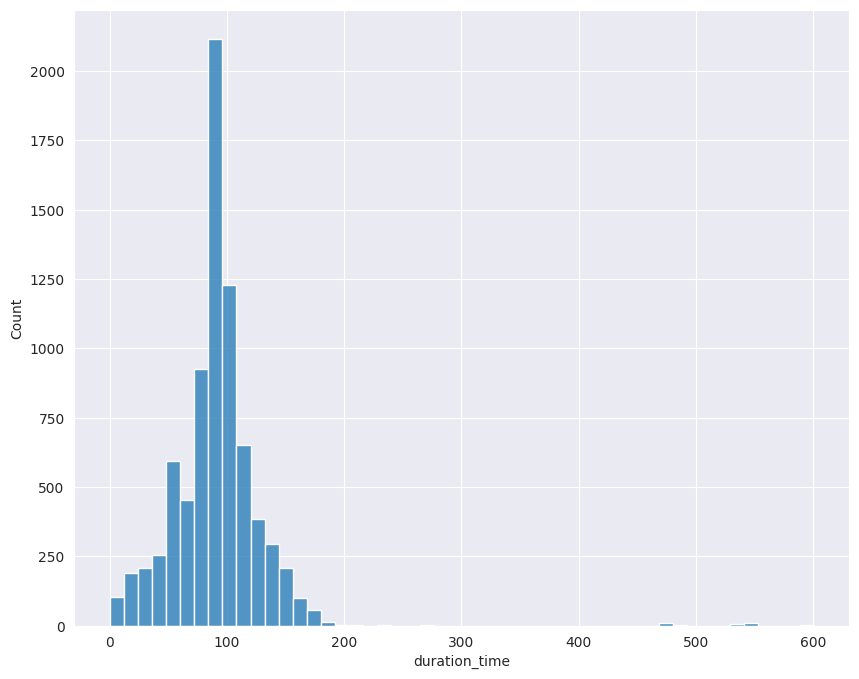

In [47]:
# plot a distribution of duration time for the movies, what do you notice?
plt.figure(figsize=(10, 8))
sns.histplot(data=df_movies, x ='duration_time', bins=50)
plt.show()

In [48]:
# give the descriptive statistics of the duration_time feature
# what do you notice?

df_movies.duration_time.describe()

count    7814.000000
mean       91.311876
std        40.333086
min         0.000000
25%        75.000000
50%        91.000000
75%       106.000000
max       601.000000
Name: duration_time, dtype: float64

In [49]:
# there's a really long tail in the distribution of times
# let's look into the tail and see what kind of movies there are.
# pick a time in minutes, say 400 and look at a sample
# of movies that have duration past that length

df_movies[df_movies.duration_time>400].sample(9)

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,genres,duration_season,duration_time
5214,s5215,Movie,Black Screen Ocean Waves for Sleep 9 hours,Mark Knight,Unknown,United States,Unknown,2017,ALL,541 min,Special Interest,This black screen recording of the winter Paci...,[Special Interest],False,541
4919,s4920,Movie,Ceiling Fan for Sleep 9 hours,Mark Knight,Unknown,United States,Unknown,2017,ALL,540 min,Special Interest,Ceiling Fan for Sleep 9 hours captures the soo...,[Special Interest],False,540
933,s934,Movie,Soothing Surf at Del Norte for Sleep black screen,Mark Knight,Unknown,United States,Unknown,2018,ALL,601 min,Special Interest,Black screen reduces the blue-spectrum light w...,[Special Interest],False,601
3445,s3446,Movie,9 Hour Rainstorm for Sleep black screen,Mark Knight,Unknown,United States,Unknown,2017,ALL,541 min,"Documentary, Special Interest","Black screen for a deep, restful sleep accompa...","[Documentary, Special Interest]",False,541
2367,s2368,Movie,Gentle Midnight Rain black screen 9 hours,Mark Knight,Unknown,United States,Unknown,2017,ALL,541 min,Special Interest,One of our most popular sleep videos is now av...,[Special Interest],False,541
3908,s3909,Movie,Box Fan for Sleep,Mark Knight,Unknown,United States,Unknown,2017,ALL,540 min,Special Interest,Box Fan for Sleep 9 hours captures the soothin...,[Special Interest],False,540
4087,s4088,Movie,Thunderstorm for sleep black screen,Mark Knight,Unknown,United States,Unknown,2017,ALL,541 min,"Documentary, Special Interest","Black screen for a deep, restful sleep accompa...","[Documentary, Special Interest]",False,541
3850,s3851,Movie,Himalayan Singing Bowls 9 hours,Mark Knight,"Niv Dayan, Sarah Lærke",United States,Unknown,2017,ALL,550 min,Special Interest,This ambient sleep and meditation video is a f...,[Special Interest],False,550
3877,s3878,Movie,Evening Rain for Sleep 8 hours,Mark Knight,Unknown,United States,Unknown,2016,ALL,480 min,Special Interest,Sharecare Windows presents sleep-inducing rain...,[Special Interest],False,480


In [50]:
# most of these really long movies are
# coming from what director?

df_movies[df_movies.duration_time>400].director.value_counts()

director
Mark Knight    24
Jim Wilmer      2
Unknown         1
Name: count, dtype: int64

Looking at the descriptions of these really long movies, it seems like they are all ambient noise movies. These movies provide white noise to aid in sleeping and relaxation.

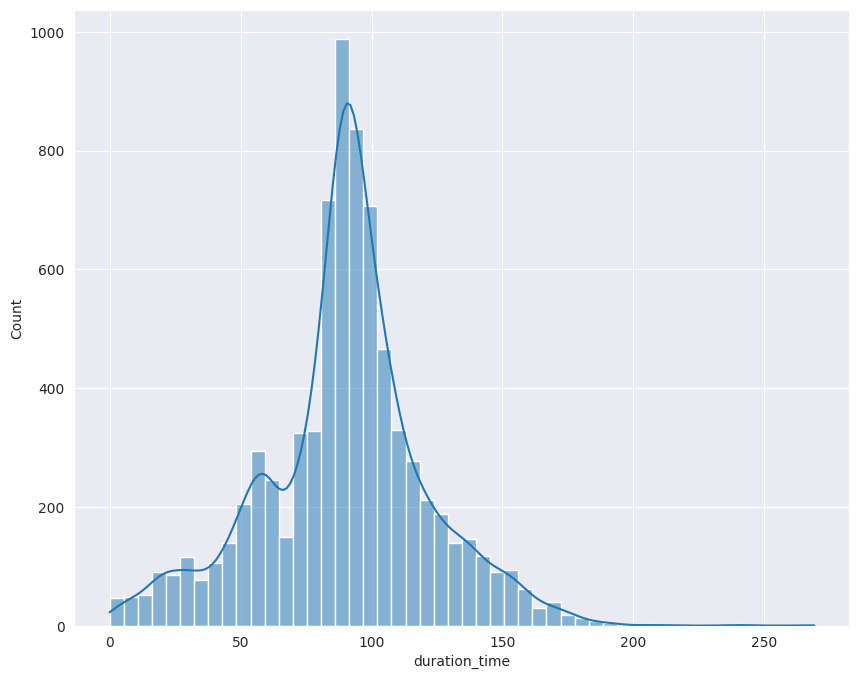

In [51]:
# removing these outliers you can see a much more symmetric curve
# of movie times. What do you notice about the movie duration times? Does it look
# similar to a type of distribution that you have seen before?
plt.figure(figsize=(10, 8))
sns.histplot(data=df_movies[df_movies.duration_time<=400],
             x ='duration_time',
             bins=50,
             kde=True)
plt.show()

In [52]:
# looks like there are also movies with <10 minutes in length? Why?
df_movies[df_movies.duration_time <= 10].listed_in.value_counts().head(15)

listed_in
Comedy                                        16
Kids                                          15
Drama                                         10
Special Interest                               7
Fitness, Special Interest                      6
Action                                         6
Animation, Kids                                4
Documentary                                    3
Action, Comedy                                 2
Animation, Kids, Music Videos and Concerts     2
Action, Drama                                  2
Action, Adventure, Comedy                      2
Music Videos and Concerts                      1
Animation, Anime, Kids                         1
Action, Adventure                              1
Name: count, dtype: int64

In [54]:
# what kind of movies are these? Notice anything about movie lengths of 0?
df_movies[df_movies.duration_time == 0].sample(3)

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,genres,duration_season,duration_time
1381,s1382,Movie,Paradise Canyon - Digitally Remastered,Carl Pierson,"John Wayne, Marion Burns, Earle Hodgins, Yakim...",United States,Unknown,1935,7+,0 min,"Action, Adventure",An undercover agent for the government is sent...,"[Action, Adventure]",False,0
8834,s8835,Movie,Molly and Me,Lewis Seiler,"Gracie Fields, Roddy McDowall, Monty Woolley, ...",United States,Unknown,1945,PG,0 min,"Arts Entertainment and Culture, Comedy","Molly (Fields), a poor struggling actress, dec...","[Arts Entertainment and Culture, Comedy]",False,0
5162,s5163,Movie,Asin_tombstone_test_target_04,Test Director,"Test Actor 1, Test Actor 2",United States,Unknown,2019,G,0 min,Comedy,asin_tombstone_test_target_04 short,[Comedy],False,0


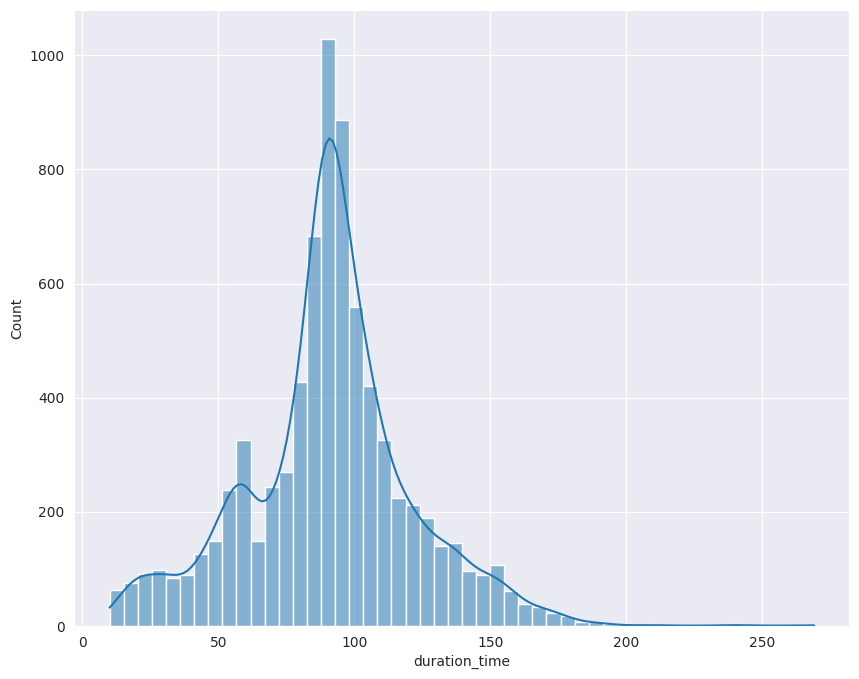

In [55]:
# removing these outliers you can see a much more normal distribution
# of movie times. What do you notice about the movie duration times?
# Does it look similar to a type of distribution that you have seen before?
plt.figure(figsize=(10, 8))
sns.histplot(data=df_movies[(df_movies.duration_time<=400) &
                            (df_movies.duration_time>=10)],
                            x ='duration_time', bins=50, kde=True)
plt.show()

In [56]:
# calcualte some general descriptive statistics of the movies lengths
df_movies[(df_movies.duration_time<=400) & (df_movies.duration_time>=10)].duration_time.describe()

count    7711.000000
mean       90.670600
std        30.495857
min        10.000000
25%        76.000000
50%        91.000000
75%       106.000000
max       269.000000
Name: duration_time, dtype: float64

### Movie Duration Exploration vs Genre
Are there any interesting insights between the genre and the duration time e.g., avg movie lengths by genre, are comedies usually shorter than dramas etc.?

In [57]:
# group by listed_in feature and look at the average
# duration time across multiple genres
df_movies.groupby('listed_in').duration_time.mean().sort_values(ascending=False)

listed_in
Comedy, Drama, Music Videos and Concerts         185.000000
Action, Arts Entertainment and Culture           165.000000
Drama, Historical, International                 163.000000
Horror, International, Science Fiction           162.000000
Drama, International, Sports                     162.000000
                                                    ...    
Fitness, Special Interest                         23.823529
Arthouse, Horror, Romance                         23.000000
Fitness                                           20.072727
Kids, Sports                                       8.000000
Arts Entertainment and Culture, Drama, Horror      7.000000
Name: duration_time, Length: 437, dtype: float64

In [58]:
## As was mentioned in the genre section, because of the duplicates
## you can't really get a full picture of how the genres relate to
## movie lengths because Drama, Comedy is considered different from Drama or Comedy.
## let's use the genres data frame to calculate more descriptive
## features by individual dramas.

# get the movies and merge them onto the genres
# df_movies merge onto df_genres, on title and listed in
# do a left join just to be safe
df_movie_genre = df_movies.merge(df_genre, on=['title', 'listed_in'], how='left')

df_movie_genre.head()

,show_id,type_x,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,genres_x,duration_season,duration_time,type_y,genres_y,Action,Adventure,Animation,Anime,Arthouse,Arts Entertainment and Culture,Comedy,Documentary,Drama,Faith and Spirituality,Fantasy,Fitness,Historical,Horror,International,Kids,LGBTQ,Military and War,Music Videos and Concerts,Romance,Science Fiction,Special Interest,Sports,Suspense,TV Shows,Talk Show and Variety,Unscripted,Western,Young Adult Audience
0,s1,Movie,The Grand Seduction,Don McKellar,"Brendan Gleeson, Taylor Kitsch, Gordon Pinsent",Canada,"March 30, 2021",2014,Unknown,113 min,"Comedy, Drama",A small fishing village must procure a local d...,"[Comedy, Drama]",False,113,Movie,"[Comedy, Drama]",0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,s2,Movie,Take Care Good Night,Girish Joshi,"Mahesh Manjrekar, Abhay Mahajan, Sachin Khedekar",India,"March 30, 2021",2018,13+,110 min,"Drama, International",A Metro Family decides to fight a Cyber Crimin...,"[Drama, International]",False,110,Movie,"[Drama, International]",0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,s3,Movie,Secrets of Deception,Josh Webber,"Tom Sizemore, Lorenzo Lamas, Robert LaSardo, R...",United States,"March 30, 2021",2017,Unknown,74 min,"Action, Drama, Suspense",After a man discovers his wife is cheating on ...,"[Action, Drama, Suspense]",False,74,Movie,"[Action, Drama, Suspense]",1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3,s4,Movie,Pink: Staying True,Sonia Anderson,"Interviews with: Pink, Adele, Beyoncé, Britney...",United States,"March 30, 2021",2014,Unknown,69 min,Documentary,"Pink breaks the mold once again, bringing her ...",[Documentary],False,69,Movie,[Documentary],0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,s5,Movie,Monster Maker,Giles Foster,"Harry Dean Stanton, Kieran O'Brien, George Cos...",United Kingdom,"March 30, 2021",1989,Unknown,45 min,"Drama, Fantasy",Teenage Matt Banting wants to work with a famo...,"[Drama, Fantasy]",False,45,Movie,"[Drama, Fantasy]",0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [59]:
# use the mlb binarizer to get the genre names
# in the form of a list. Make sure to remove TV shows
# since those aren't measure in minutes
genres = [genre for genre in mlb.classes_.tolist() if genre != 'TV Shows']

In [60]:
# intiial group by that we'll be calculating
df_movie_genre.groupby('Action').duration_time.agg(['size','mean']).reset_index()

,Action,size,mean
0,0,6312,88.997782
1,1,1502,101.036618


In [61]:
# create an empty dictionary that
# will keep track of genres and their avg minutes
genre_duration_time_dict = {}

# go through each genre, find the average duration time
# and place that value in the dictionary with the genre as a key
for genre in genres:
  # group by to get total movies per genre and their avg time
  gen_df = df_movie_genre.groupby(f'{genre}')\
                         .duration_time\
                         .agg(['size','mean'])\
                         .reset_index()
  # get the total number of movies for the genre
  size_duration = gen_df[gen_df[f'{genre}'] == 1]['size'].iloc[0]
  # get the avg movie length per genre
  avg_duration = gen_df[gen_df[f'{genre}'] == 1]['mean'].iloc[0]
  # assign the value in a dictionary
  genre_duration_time_dict[f'{genre}'] = [size_duration, avg_duration]

In [62]:
genre_duration_time_dict

{'Action': [1502, 101.03661784287617],
 'Adventure': [230, 101.09130434782608],
 'Animation': [279, 53.85663082437276],
 'Anime': [29, 74.17241379310344],
 'Arthouse': [140, 92.69285714285714],
 'Arts Entertainment and Culture': [444, 74.74774774774775],
 'Comedy': [1821, 91.82207578253707],
 'Documentary': [679, 81.58026509572902],
 'Drama': [3206, 101.76512788521522],
 'Faith and Spirituality': [57, 86.94736842105263],
 'Fantasy': [51, 101.0],
 'Fitness': [72, 20.958333333333332],
 'Historical': [12, 118.25],
 'Horror': [845, 89.19171597633137],
 'International': [284, 130.65845070422534],
 'Kids': [679, 58.55964653902798],
 'LGBTQ': [91, 90.05494505494505],
 'Military and War': [36, 92.22222222222223],
 'Music Videos and Concerts': [149, 57.79194630872483],
 'Romance': [592, 110.91891891891892],
 'Science Fiction': [399, 91.72932330827068],
 'Special Interest': [707, 84.78217821782178],
 'Sports': [106, 86.77358490566037],
 'Suspense': [1381, 96.48950036205648],
 'Talk Show and Vari

In [63]:
# use the pandas from_dict method to turn the previous
# dictionary into a pandas data frame
gen_duration_time_df = pd.DataFrame.from_dict(genre_duration_time_dict,
                                              orient='index',
                                              columns=['num_movies_with_genre',
                                                       'avg_duration_time'])\
                                              .reset_index(names='genre')
# sort out the values from in descending order, what do you notice?
gen_duration_time_df.sort_values('avg_duration_time', ascending=False)

,genre,num_movies_with_genre,avg_duration_time
14,International,284,130.658451
12,Historical,12,118.250000
19,Romance,592,110.918919
8,Drama,3206,101.765128
1,Adventure,230,101.091304
0,Action,1502,101.036618
10,Fantasy,51,101.000000
23,Suspense,1381,96.489500
27,Young Adult Audience,75,93.560000
4,Arthouse,140,92.692857


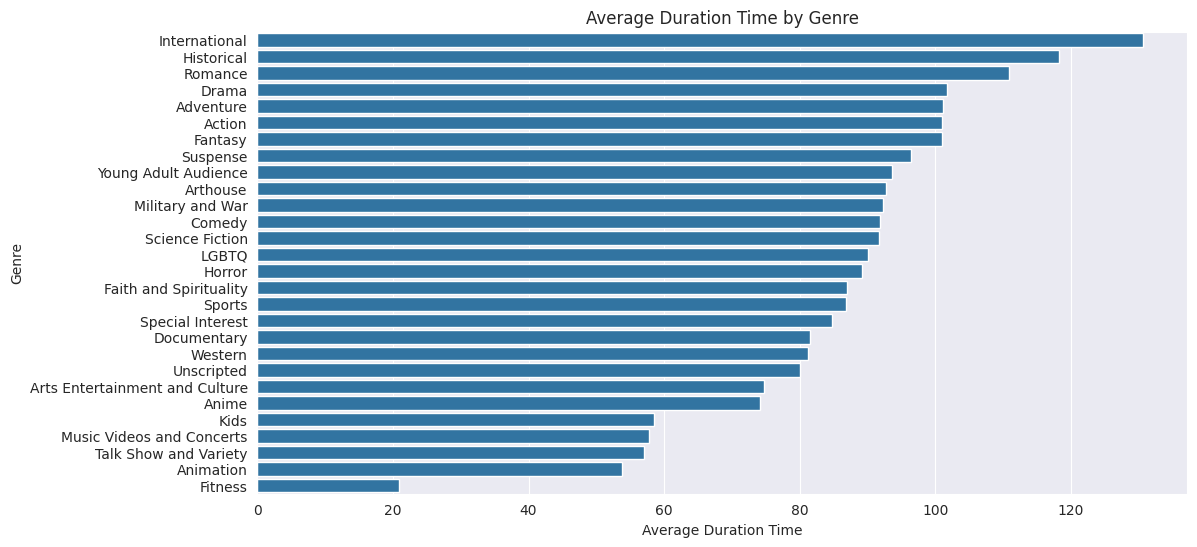

In [64]:
# give a bar plot representation for this
plt.figure(figsize=(12, 6))
sns.barplot(data=gen_duration_time_df.sort_values('avg_duration_time', ascending=False),
            y='genre',
            x='avg_duration_time')
plt.title('Average Duration Time by Genre')
plt.ylabel('Genre')
plt.xlabel('Average Duration Time')
# plt.savefig('avg_duration.png',  bbox_inches='tight')
plt.gcf()
plt.show()

## TV Shows Duration Exploration
Explore some general behavior of TV shows duration and a breakdown by genre.  

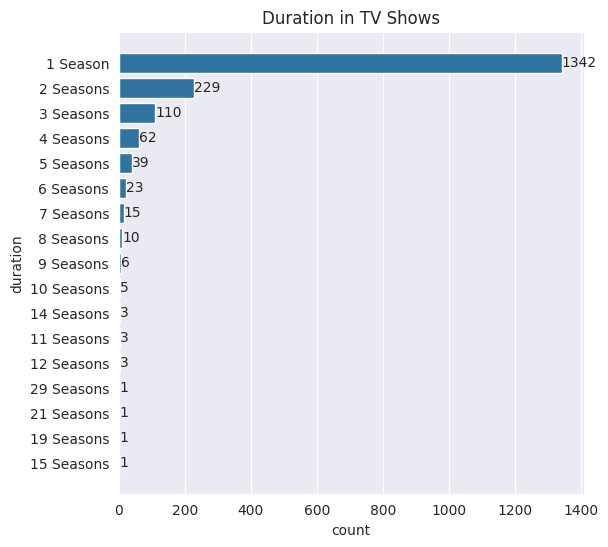

In [102]:
# Do it again for TV Shows
## get all the tv shows
df_shows = df[df.duration_season==True].copy()

plt.figure(figsize=(6, 6))
ax = sns.countplot(data = df_shows,
                   y='duration',
                   order = df_shows['duration'].value_counts().index)
plt.title('Duration in TV Shows')
ax.bar_label(ax.containers[0])
plt.plot();

In [103]:
# are there duplicate shows, for example 1 show can have 1 season and 2 seasons
# looks like no duplicate titles
df_shows.title.duplicated().sum()

0

In [104]:
# 12 percent of tv shows on prime only have two seasons!
df_shows['duration'].value_counts()/len(df_shows) * 100

duration
1 Season      72.384035
2 Seasons     12.351672
3 Seasons      5.933118
4 Seasons      3.344121
5 Seasons      2.103560
6 Seasons      1.240561
7 Seasons      0.809061
8 Seasons      0.539374
9 Seasons      0.323625
10 Seasons     0.269687
14 Seasons     0.161812
11 Seasons     0.161812
12 Seasons     0.161812
29 Seasons     0.053937
21 Seasons     0.053937
19 Seasons     0.053937
15 Seasons     0.053937
Name: count, dtype: float64

#### How do TV show seasons relate to release year?

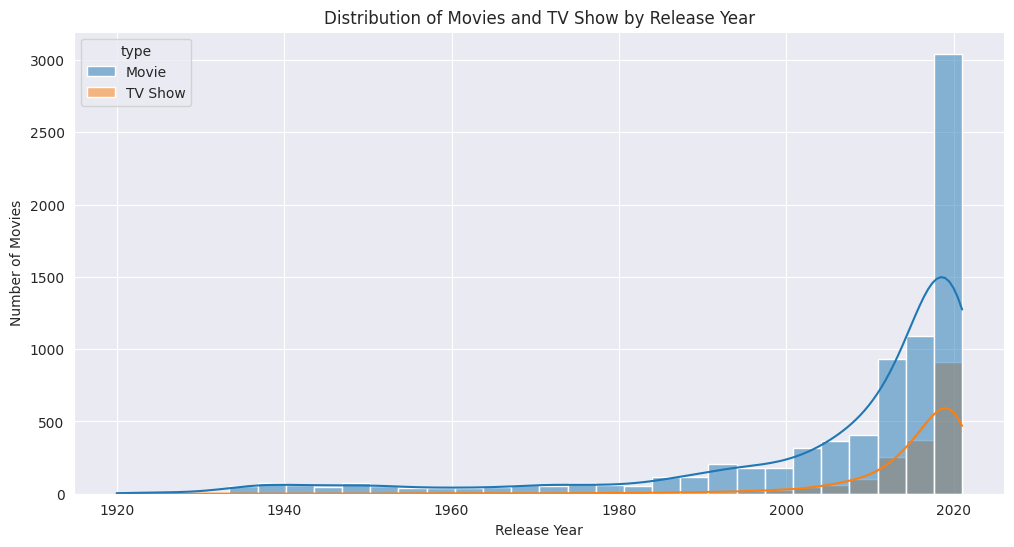

In [105]:
# Distribution of movies by release year for movies and tv shows
plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='release_year', bins=30, kde=True, hue='type')
plt.title('Distribution of Movies and TV Show by Release Year')
plt.xlabel('Release Year')
plt.ylabel('Number of Movies')
plt.show()

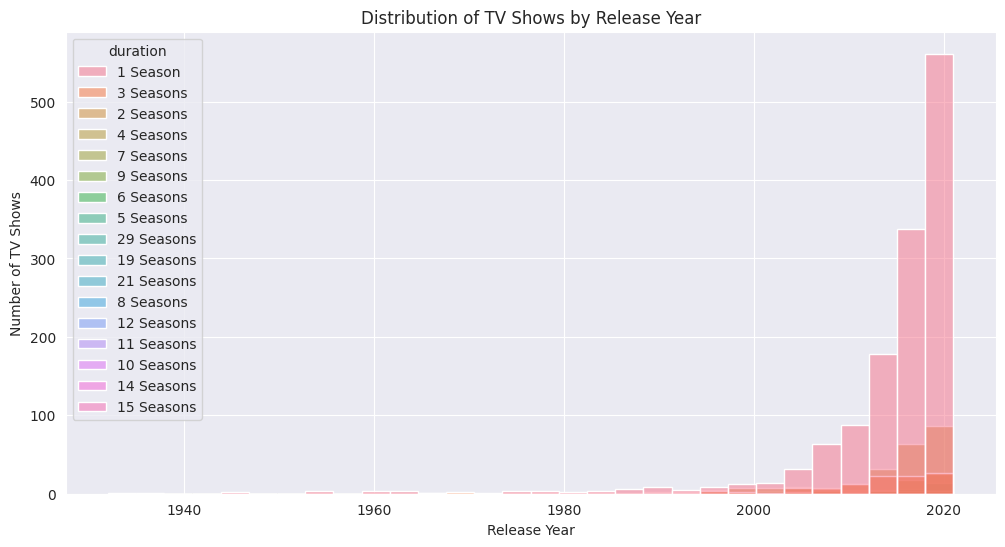

In [106]:
# Distribution of movies by release year
# at this point we can notice that tons of tv shows
# only have 1 season
plt.figure(figsize=(12, 6))
sns.histplot(data=df_shows, x='release_year', bins=30, hue='duration')
plt.title('Distribution of TV Shows by Release Year')
plt.xlabel('Release Year')
plt.ylabel('Number of TV Shows')
plt.show()

Can probably infer that the majority of TV shows that have 1 season were created fairly recently. Let's see if we can validate that.

In [107]:
#because there are not many shows before 1990, let's remove those and
# see what the distribution of 1 season shows looks like
df_shows_new = df_shows[df_shows.release_year>=1990]
df_shows_unstack = df_shows_new.groupby(['duration', 'release_year'])\
                               .duration.count()\
                               .to_frame().unstack().fillna(0).iloc[:, -22:]
df_shows_unstack

duration                                                          \
release_year     2000 2001 2002 2003  2004  2005 2006  2007  2008  2009  2010   
duration                                                                        
1 Season          5.0  3.0  6.0  5.0  11.0  13.0  8.0  13.0  30.0  21.0  24.0   
10 Seasons        0.0  0.0  0.0  0.0   0.0   0.0  0.0   0.0   0.0   1.0   0.0   
11 Seasons        0.0  0.0  0.0  0.0   0.0   0.0  0.0   0.0   0.0   0.0   0.0   
12 Seasons        0.0  0.0  1.0  0.0   0.0   0.0  0.0   0.0   0.0   0.0   0.0   
14 Seasons        0.0  0.0  1.0  0.0   0.0   0.0  0.0   0.0   0.0   0.0   1.0   
15 Seasons        0.0  0.0  0.0  0.0   0.0   0.0  0.0   0.0   0.0   0.0   0.0   
19 Seasons        0.0  0.0  0.0  0.0   0.0   0.0  0.0   0.0   0.0   0.0   0.0   
2 Seasons         3.0  3.0  0.0  4.0   0.0   1.0  1.0   2.0   0.0   4.0   2.0   
21 Seasons        0.0  0.0  0.0  0.0   0.0   0.0  0.0   0.0   0.0   0.0   0.0   
29 Seasons        0.0  0.0  0.0  0.0   0.0   0.0  0.0   0.0   0.0   0.0   0.0   
3 Seasons         0.0  0.0  0.0  1.0   0.0   4.0  3.0   2.0   1.0   4.0   5.0   
4 Seasons         1.0  1.0  0.0  0.0   3.0   2.0  3.0   1.0   2.0   0.0   1.0   
5 Seasons         0.0  0.0  0.0  1.0   0.0   0.0  3.0   1.0   0.0   0.0   0.0   
6 Seasons         0.0  1.0  0.0  0.0   0.0   1.0  0.0   0.0   0.0   1.0   0.0   
7 Seasons         0.0  1.0  1.0  2.0   0.0   0.0  0.0   0.0   0.0   0.0   0.0   
8 Seasons         0.0  0.0  0.0  0.0   0.0   0.0  0.0   0.0   0.0   1.0   0.0   
9 Seasons         0.0  0.0  0.0  0.0   0.0   0.0  0.0   0.0   0.0   0.0   1.0   

                                                                              \
release_year  2011  2012  2013  2014  2015  2016   2017   2018   2019   2020   
duration                                                                       
1 Season      27.0  37.0  46.0  66.0  66.0  81.0  120.0  137.0  134.0  181.0   
10 Seasons     0.0   0.0   0.0   1.0   1.0   1.0    0.0    0.0    0.0    0.0   
11 Seasons     0.0   0.0   0.0   0.0   1.0   0.0    0.0    0.0    0.0    1.0   
12 Seasons     1.0   0.0   0.0   0.0   0.0   0.0    1.0    0.0    0.0    0.0   
14 Seasons     0.0   0.0   0.0   0.0   0.0   0.0    0.0    0.0    0.0    0.0   
15 Seasons     0.0   0.0   0.0   0.0   0.0   0.0    0.0    1.0    0.0    0.0   
19 Seasons     0.0   0.0   0.0   1.0   0.0   0.0    0.0    0.0    0.0    0.0   
2 Seasons      6.0   5.0   6.0  13.0  13.0  21.0   20.0   23.0   27.0   26.0   
21 Seasons     0.0   0.0   0.0   0.0   0.0   0.0    0.0    1.0    0.0    0.0   
29 Seasons     0.0   0.0   0.0   0.0   0.0   0.0    1.0    0.0    0.0    0.0   
3 Seasons      4.0   3.0   6.0   7.0  10.0   8.0    5.0   10.0   13.0    4.0   
4 Seasons      0.0   1.0   2.0   1.0   1.0   5.0    5.0    7.0   13.0    6.0   
5 Seasons      1.0   4.0   1.0   4.0   0.0   2.0    2.0    2.0    8.0    4.0   
6 Seasons      0.0   4.0   0.0   2.0   2.0   1.0    2.0    1.0    2.0    1.0   
7 Seasons      0.0   0.0   0.0   0.0   1.0   0.0    1.0    2.0    0.0    2.0   
8 Seasons      1.0   1.0   1.0   1.0   1.0   0.0    0.0    1.0    0.0    0.0   
9 Seasons      0.0   0.0   0.0   0.0   0.0   0.0    1.0    0.0    2.0    1.0   

                     
release_year   2021  
duration             
1 Season      246.0  
10 Seasons      1.0  
11 Seasons      1.0  
12 Seasons      0.0  
14 Seasons      1.0  
15 Seasons      0.0  
19 Seasons      0.0  
2 Seasons      33.0  
21 Seasons      0.0  
29 Seasons      0.0  
3 Seasons      10.0  
4 Seasons       6.0  
5 Seasons       2.0  
6 Seasons       1.0  
7 Seasons       1.0  
8 Seasons       1.0  
9 Seasons       0.0

In [108]:
# don't like things being out of order
# so let's go ahead and reorder them
unstacked_indexes = df_shows_unstack.index.tolist()
ordered_season_num = sorted([int(x.split(' ')[0]) for x in unstacked_indexes])

ordered_seasons = []
for num in ordered_season_num:
    for duration in  unstacked_indexes:
        if re.search(fr'^\b({num})\b', f'{duration}'):
            ordered_seasons.append(duration)
ordered_seasons

['1 Season',
 '2 Seasons',
 '3 Seasons',
 '4 Seasons',
 '5 Seasons',
 '6 Seasons',
 '7 Seasons',
 '8 Seasons',
 '9 Seasons',
 '10 Seasons',
 '11 Seasons',
 '12 Seasons',
 '14 Seasons',
 '15 Seasons',
 '19 Seasons',
 '21 Seasons',
 '29 Seasons']

In [109]:
# groupby the duration and release year, count the
# number of times that this these occur together
# unpivot using unstack and place it into
# a nice pandas dataframe from the year 2000 onwards
df_shows_gpby = df_shows_new.groupby(['duration', 'release_year'])\
                            .duration.count().rename('release_year')\
                            .to_frame().unstack()\
                            .fillna(0).iloc[:, -22:]\
                            .reindex(ordered_seasons)
df_shows_gpby

release_year                                                    \
release_year         2000 2001 2002 2003  2004  2005 2006  2007  2008  2009   
duration                                                                      
1 Season              5.0  3.0  6.0  5.0  11.0  13.0  8.0  13.0  30.0  21.0   
2 Seasons             3.0  3.0  0.0  4.0   0.0   1.0  1.0   2.0   0.0   4.0   
3 Seasons             0.0  0.0  0.0  1.0   0.0   4.0  3.0   2.0   1.0   4.0   
4 Seasons             1.0  1.0  0.0  0.0   3.0   2.0  3.0   1.0   2.0   0.0   
5 Seasons             0.0  0.0  0.0  1.0   0.0   0.0  3.0   1.0   0.0   0.0   
6 Seasons             0.0  1.0  0.0  0.0   0.0   1.0  0.0   0.0   0.0   1.0   
7 Seasons             0.0  1.0  1.0  2.0   0.0   0.0  0.0   0.0   0.0   0.0   
8 Seasons             0.0  0.0  0.0  0.0   0.0   0.0  0.0   0.0   0.0   1.0   
9 Seasons             0.0  0.0  0.0  0.0   0.0   0.0  0.0   0.0   0.0   0.0   
10 Seasons            0.0  0.0  0.0  0.0   0.0   0.0  0.0   0.0   0.0   1.0   
11 Seasons            0.0  0.0  0.0  0.0   0.0   0.0  0.0   0.0   0.0   0.0   
12 Seasons            0.0  0.0  1.0  0.0   0.0   0.0  0.0   0.0   0.0   0.0   
14 Seasons            0.0  0.0  1.0  0.0   0.0   0.0  0.0   0.0   0.0   0.0   
15 Seasons            0.0  0.0  0.0  0.0   0.0   0.0  0.0   0.0   0.0   0.0   
19 Seasons            0.0  0.0  0.0  0.0   0.0   0.0  0.0   0.0   0.0   0.0   
21 Seasons            0.0  0.0  0.0  0.0   0.0   0.0  0.0   0.0   0.0   0.0   
29 Seasons            0.0  0.0  0.0  0.0   0.0   0.0  0.0   0.0   0.0   0.0   

                                                                             \
release_year  2010  2011  2012  2013  2014  2015  2016   2017   2018   2019   
duration                                                                      
1 Season      24.0  27.0  37.0  46.0  66.0  66.0  81.0  120.0  137.0  134.0   
2 Seasons      2.0   6.0   5.0   6.0  13.0  13.0  21.0   20.0   23.0   27.0   
3 Seasons      5.0   4.0   3.0   6.0   7.0  10.0   8.0    5.0   10.0   13.0   
4 Seasons      1.0   0.0   1.0   2.0   1.0   1.0   5.0    5.0    7.0   13.0   
5 Seasons      0.0   1.0   4.0   1.0   4.0   0.0   2.0    2.0    2.0    8.0   
6 Seasons      0.0   0.0   4.0   0.0   2.0   2.0   1.0    2.0    1.0    2.0   
7 Seasons      0.0   0.0   0.0   0.0   0.0   1.0   0.0    1.0    2.0    0.0   
8 Seasons      0.0   1.0   1.0   1.0   1.0   1.0   0.0    0.0    1.0    0.0   
9 Seasons      1.0   0.0   0.0   0.0   0.0   0.0   0.0    1.0    0.0    2.0   
10 Seasons     0.0   0.0   0.0   0.0   1.0   1.0   1.0    0.0    0.0    0.0   
11 Seasons     0.0   0.0   0.0   0.0   0.0   1.0   0.0    0.0    0.0    0.0   
12 Seasons     0.0   1.0   0.0   0.0   0.0   0.0   0.0    1.0    0.0    0.0   
14 Seasons     1.0   0.0   0.0   0.0   0.0   0.0   0.0    0.0    0.0    0.0   
15 Seasons     0.0   0.0   0.0   0.0   0.0   0.0   0.0    0.0    1.0    0.0   
19 Seasons     0.0   0.0   0.0   0.0   1.0   0.0   0.0    0.0    0.0    0.0   
21 Seasons     0.0   0.0   0.0   0.0   0.0   0.0   0.0    0.0    1.0    0.0   
29 Seasons     0.0   0.0   0.0   0.0   0.0   0.0   0.0    1.0    0.0    0.0   

                            
release_year   2020   2021  
duration                    
1 Season      181.0  246.0  
2 Seasons      26.0   33.0  
3 Seasons       4.0   10.0  
4 Seasons       6.0    6.0  
5 Seasons       4.0    2.0  
6 Seasons       1.0    1.0  
7 Seasons       2.0    1.0  
8 Seasons       0.0    1.0  
9 Seasons       1.0    0.0  
10 Seasons      0.0    1.0  
11 Seasons      1.0    1.0  
12 Seasons      0.0    0.0  
14 Seasons      0.0    1.0  
15 Seasons      0.0    0.0  
19 Seasons      0.0    0.0  
21 Seasons      0.0    0.0  
29 Seasons      0.0    0.0

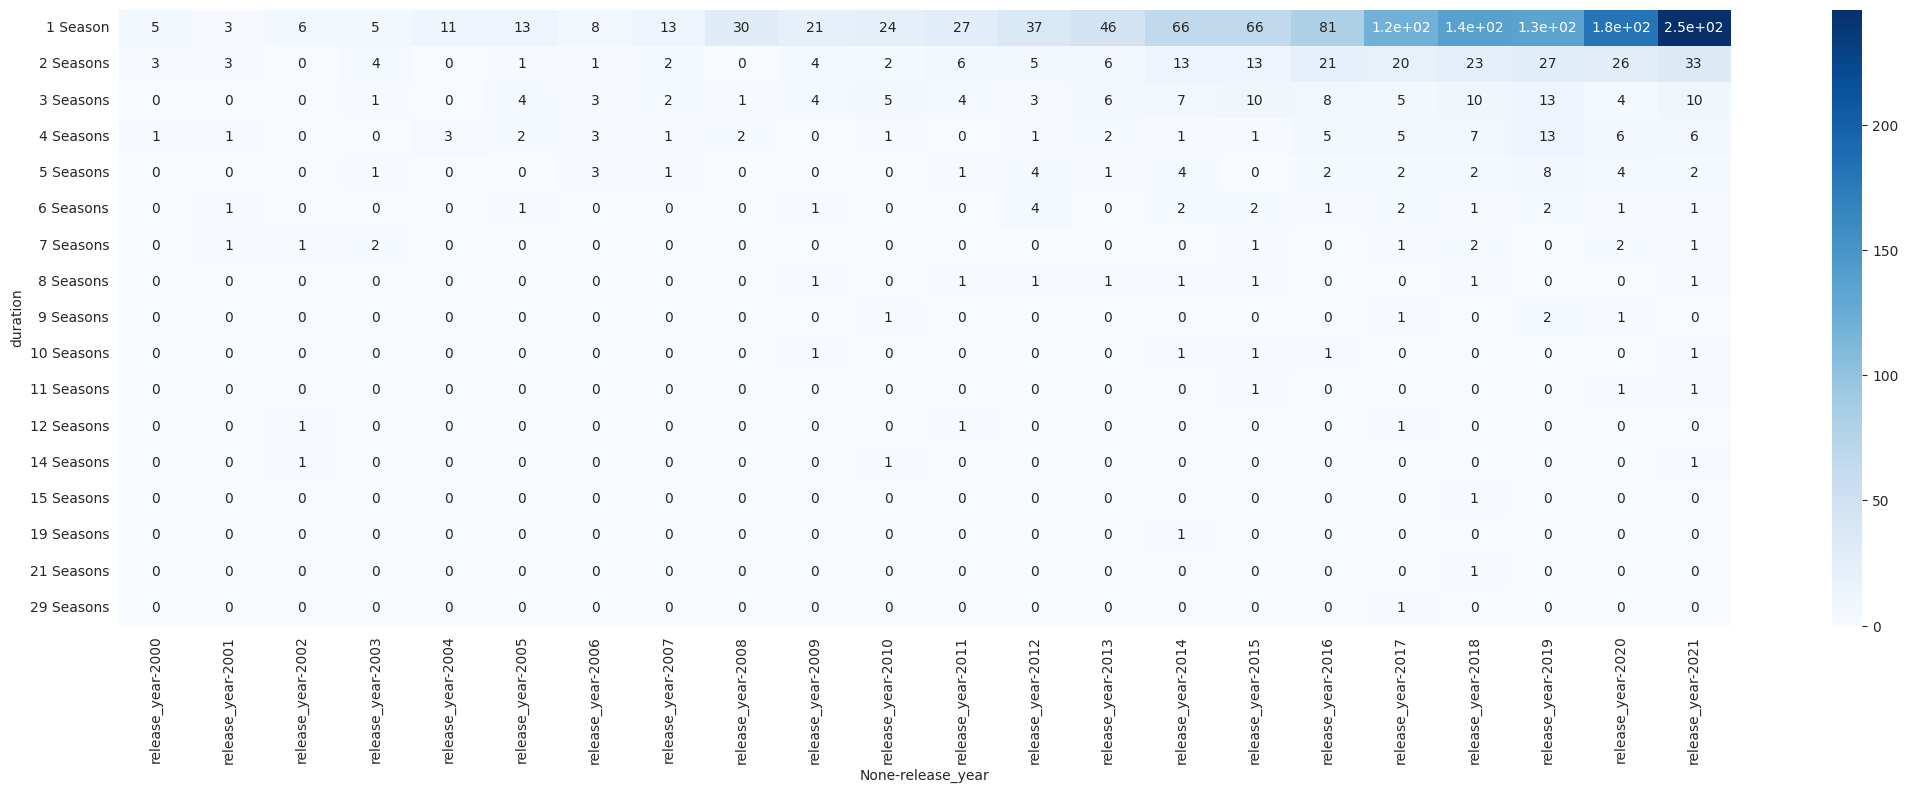

In [110]:
# plot a heatmap equivalent of this dataframe
plt.figure(figsize=(26, 8))
sns.heatmap(df_shows_gpby, cmap="Blues", annot=True)
plt.show()

In [111]:
# sum across the columns to show how many
# tv shows have 1 season, 2 season, 3 season etc.
df_shows_gpby.sum(axis=1)

duration
1 Season      1280.0
2 Seasons      213.0
3 Seasons      100.0
4 Seasons       61.0
5 Seasons       35.0
6 Seasons       19.0
7 Seasons       11.0
8 Seasons        8.0
9 Seasons        5.0
10 Seasons       5.0
11 Seasons       3.0
12 Seasons       3.0
14 Seasons       3.0
15 Seasons       1.0
19 Seasons       1.0
21 Seasons       1.0
29 Seasons       1.0
dtype: float64

Interesting that 1280 out of the 1342 of the shows that have 1 season were released in 2000 or later. What do we think this means?

In [112]:
df_shows[df_shows.duration == '14 Seasons'].title.values.tolist()

["America's Next Top Model",
 "Paula's Best Dishes",
 'My Magic Pet Morphle - Adventures of Mila & Morphle']

#### TV Shows Season Duration vs Genres
Can we see a breakdown of TV shows season lengths vs the genres of those tv shows. Do certain genres last longer than others at least on Amazon prime.

In [113]:
# using the python split method
# get the season length of each tv show
df_shows['season_length'] = df_shows.duration.apply(lambda x : int(x.split(' ')[0]))
df_shows.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,genres,duration_season,description_length,season_length
17,s18,TV Show,Zoo Babies,Unknown,Narrator - Gillian Barlett,United States,Unknown,2008,ALL,1 Season,"Kids, Special Interest",A heart warming and inspiring series that welc...,"[Kids, Special Interest]",True,51,1
18,s19,TV Show,Zoë Coombs Marr: Bossy Bottom,Unknown,Zoë Coombs Marr,United States,Unknown,2020,18+,1 Season,"Comedy, Talk Show and Variety",Zoë Coombs Marr has been on hiatus. Sort of. F...,"[Comedy, Talk Show and Variety]",True,69,1
20,s21,TV Show,Zoboomafoo,Unknown,Unknown,United States,Unknown,2001,TV-Y,1 Season,Kids,Chris and Martin Kratt bring their enthusiasm ...,[Kids],True,13,1
21,s22,TV Show,Zo Zo Zombie: Mini-Series,Unknown,"Alex Cazares, Ben Diskin, Cristina Vee, Erika ...",United States,Unknown,2020,TV-Y7,1 Season,"Action, Anime, Comedy","Zo Zo Zombie is our undead hero who, with his ...","[Action, Anime, Comedy]",True,32,1
23,s24,TV Show,ZeroZeroZero,Unknown,"ANDREA RISEBOROUGH, HAROLD TORRES, CLAUDIA PIN...",Italy,Unknown,2020,18+,1 Season,TV Shows,ZeroZeroZero series follows the journey of a c...,[TV Shows],True,42,1


In [114]:
# similar to the movies portion above, take the shows data frame
# and merge it on the genres data frame
df_shows_genre = df_shows.merge(df_genre, on=['title', 'listed_in'], how='left')
df_shows_genre.head()

,show_id,type_x,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,genres_x,duration_season,description_length,season_length,type_y,genres_y,Action,Adventure,Animation,Anime,Arthouse,Arts Entertainment and Culture,Comedy,Documentary,Drama,Faith and Spirituality,Fantasy,Fitness,Historical,Horror,International,Kids,LGBTQ,Military and War,Music Videos and Concerts,Romance,Science Fiction,Special Interest,Sports,Suspense,TV Shows,Talk Show and Variety,Unscripted,Western,Young Adult Audience
0,s18,TV Show,Zoo Babies,Unknown,Narrator - Gillian Barlett,United States,Unknown,2008,ALL,1 Season,"Kids, Special Interest",A heart warming and inspiring series that welc...,"[Kids, Special Interest]",True,51,1,TV Show,"[Kids, Special Interest]",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0
1,s19,TV Show,Zoë Coombs Marr: Bossy Bottom,Unknown,Zoë Coombs Marr,United States,Unknown,2020,18+,1 Season,"Comedy, Talk Show and Variety",Zoë Coombs Marr has been on hiatus. Sort of. F...,"[Comedy, Talk Show and Variety]",True,69,1,TV Show,"[Comedy, Talk Show and Variety]",0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2,s21,TV Show,Zoboomafoo,Unknown,Unknown,United States,Unknown,2001,TV-Y,1 Season,Kids,Chris and Martin Kratt bring their enthusiasm ...,[Kids],True,13,1,TV Show,[Kids],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,s22,TV Show,Zo Zo Zombie: Mini-Series,Unknown,"Alex Cazares, Ben Diskin, Cristina Vee, Erika ...",United States,Unknown,2020,TV-Y7,1 Season,"Action, Anime, Comedy","Zo Zo Zombie is our undead hero who, with his ...","[Action, Anime, Comedy]",True,32,1,TV Show,"[Action, Anime, Comedy]",1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,s24,TV Show,ZeroZeroZero,Unknown,"ANDREA RISEBOROUGH, HAROLD TORRES, CLAUDIA PIN...",Italy,Unknown,2020,18+,1 Season,TV Shows,ZeroZeroZero series follows the journey of a c...,[TV Shows],True,42,1,TV Show,[TV Shows],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


In [115]:
# create an empty dictionary
genre_duration_time_dict_shows = {}

# go through each genre, find the average duration time
# and place that value in the dictionary with the genre as a key
for genre in genres:
  # group by to get total movies per genre and their avg time
  gen_df = df_shows_genre.groupby(f'{genre}')\
                         .season_length\
                         .agg(['size','mean'])\
                         .reset_index()
  # get the total number of movies for the genre
  size_duration = gen_df[gen_df[f'{genre}'] == 1]['size'].iloc[0]
  # get the avg movie length per genre
  avg_duration = gen_df[gen_df[f'{genre}'] == 1]['mean'].iloc[0]
  # assign the value in a dictionary
  genre_duration_time_dict_shows[f'{genre}'] = [size_duration, avg_duration]

In [116]:
# genre_duration_time_dict_shows

In [117]:
# use the pandas from_dict method to turn the previous
# dictionary into a pandas data frame
gen_duration_time_df_shows = pd.DataFrame.from_dict(genre_duration_time_dict_shows,
                                              orient='index',
                                              columns=['num_shows_with_genre', 'avg_duration_time'])\
                                              .reset_index(names='genre')
# sort out the values from in descending order, what do you notice?
gen_duration_time_df_shows.sort_values('avg_duration_time', ascending=False)

,genre,num_shows_with_genre,avg_duration_time
12,Historical,19,2.684211
20,Science Fiction,58,2.086207
25,Unscripted,151,2.072848
6,Comedy,278,1.992806
23,Suspense,120,1.966667
15,Kids,406,1.940887
1,Adventure,29,1.793103
27,Young Adult Audience,12,1.750000
2,Animation,268,1.746269
0,Action,155,1.722581


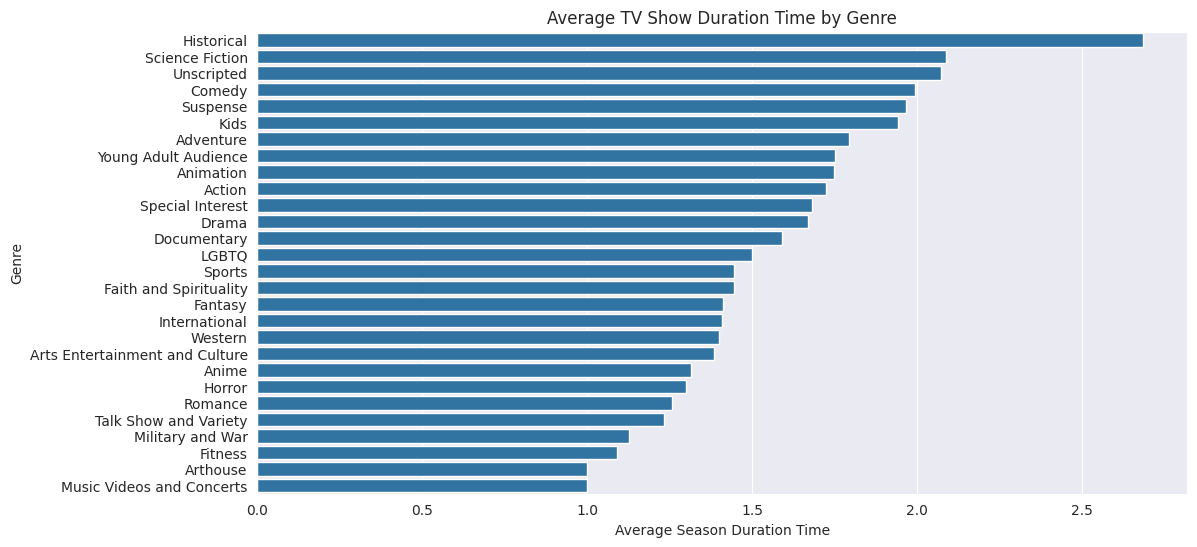

In [118]:
# give a bar plot representation for this
plt.figure(figsize=(12, 6))
sns.barplot(data=gen_duration_time_df_shows.sort_values('avg_duration_time', ascending=False),
            y='genre',
            x='avg_duration_time')
plt.title('Average TV Show Duration Time by Genre')
plt.ylabel('Genre')
plt.xlabel('Average Season Duration Time')
# plt.savefig('avg_duration.png',  bbox_inches='tight')
# plt.gcf()
plt.show()

# Country Breakdown
Are there any insights to be had broken down by country? Let's plot some descriptive plots to visualize things like duration.

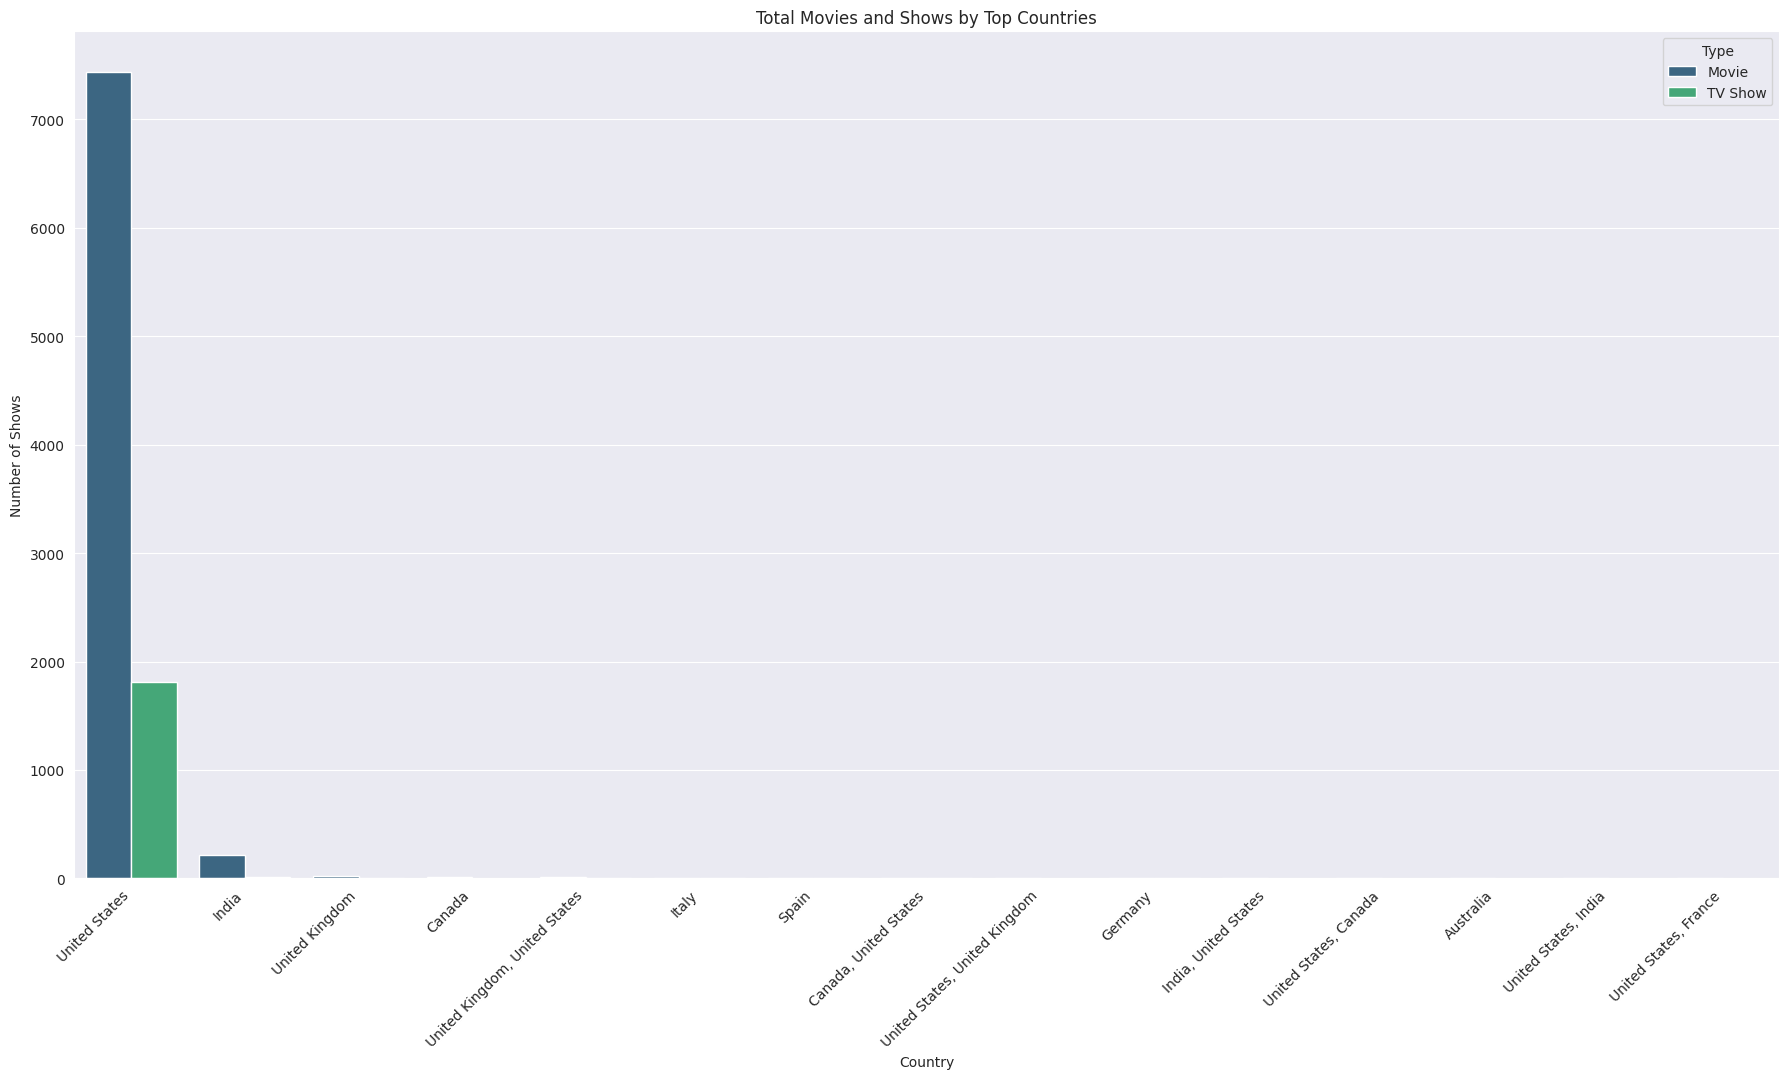

In [119]:
# plot the top 15 countries by how they appear in the
# data set
top_countries = df['country'].value_counts().head(15).index

# Filter the data for the top countries
country_data = df[df['country'].isin(top_countries)]

# Visualize the total movies and tv shows for the top countries
plt.figure(figsize=(22, 11))
sns.countplot(x='country',
              data=country_data,
              hue='type',
              order=top_countries,
              palette='viridis')
plt.title('Total Movies and Shows by Top Countries')
plt.xlabel('Country')
plt.ylabel('Number of Shows')
plt.legend(title='Type', loc='upper right')
plt.xticks(rotation=45, ha='right')
plt.show()

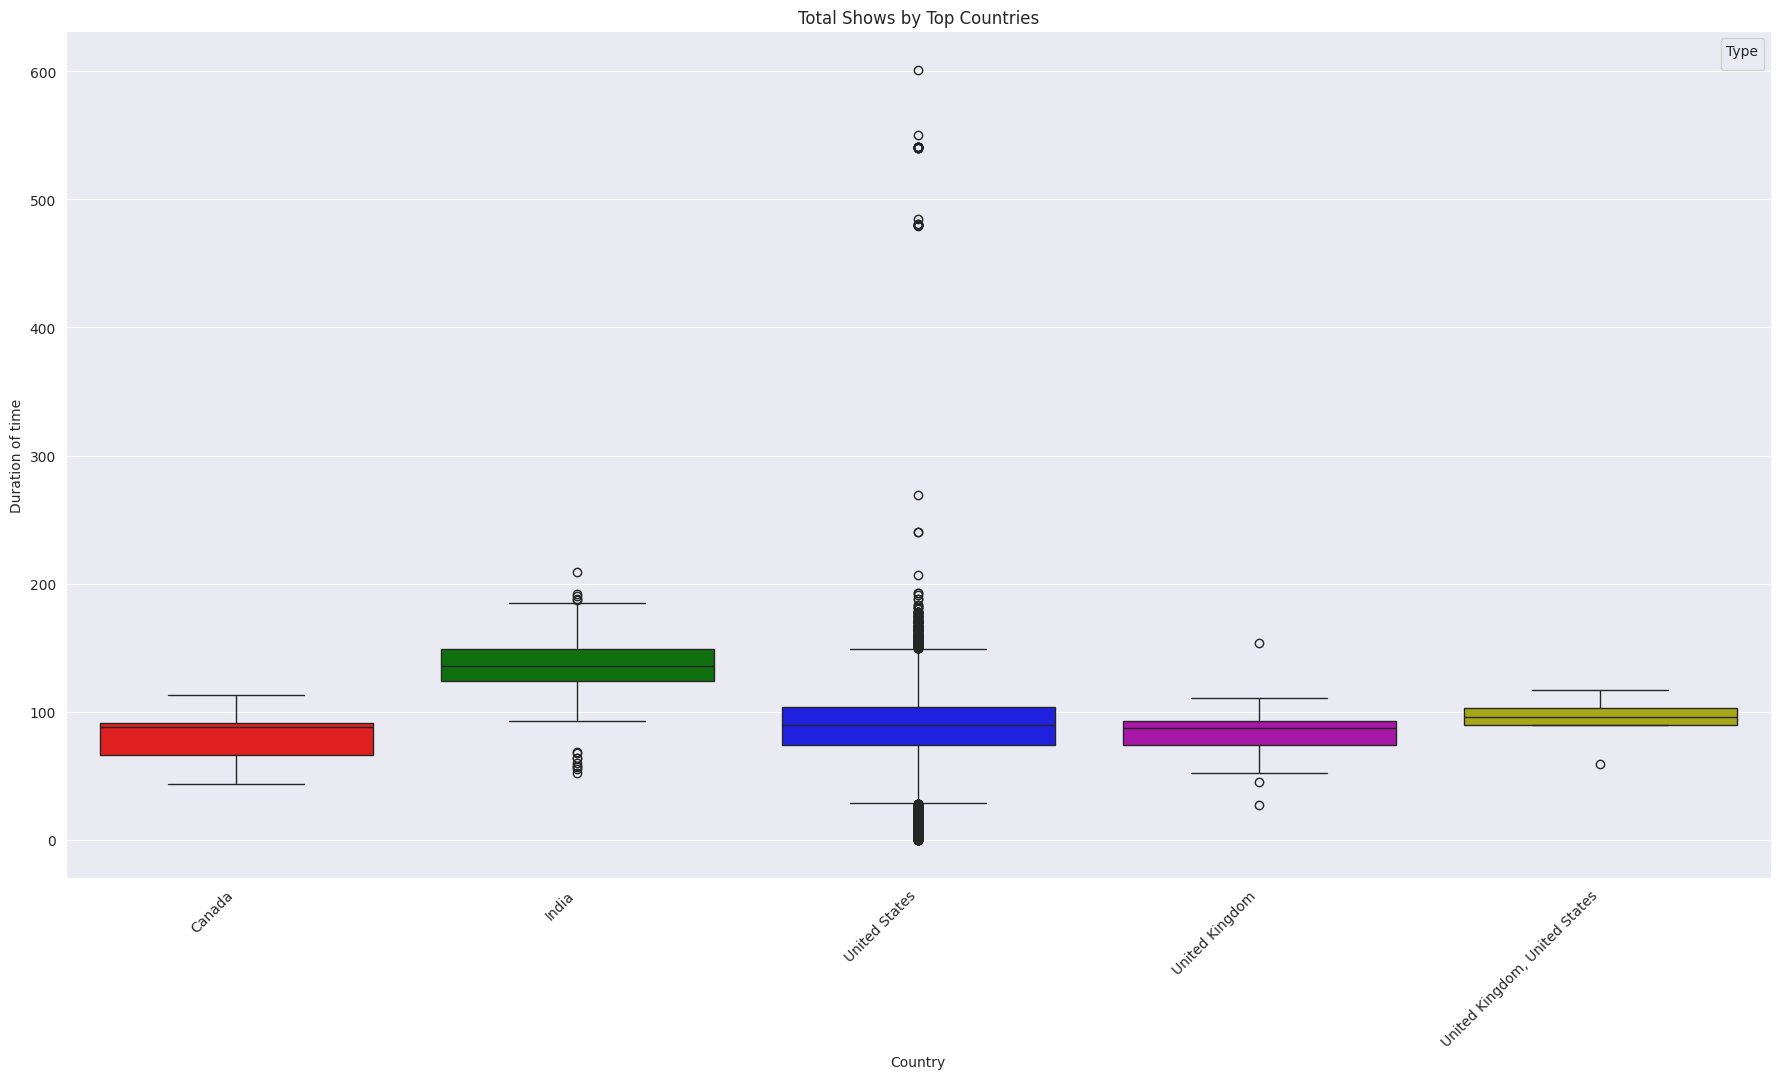

In [120]:
# Visualize the total shows by country for the top countries
# Top N countries
top_countries = df['country'].value_counts().head(5).index

df_movies_top_countries = df_movies[df_movies.country.isin(top_countries)]

plt.figure(figsize=(22, 11))
sns.boxplot(x='country',
            data=df_movies_top_countries,
            y='duration_time',
            hue='country',
            palette=['r','g','b','m', 'y'])
plt.title('Total Shows by Top Countries')
plt.xlabel('Country')
plt.ylabel('Duration of time')
plt.legend(title='Type', loc='upper right')
plt.xticks(rotation=45, ha='right')
plt.show();

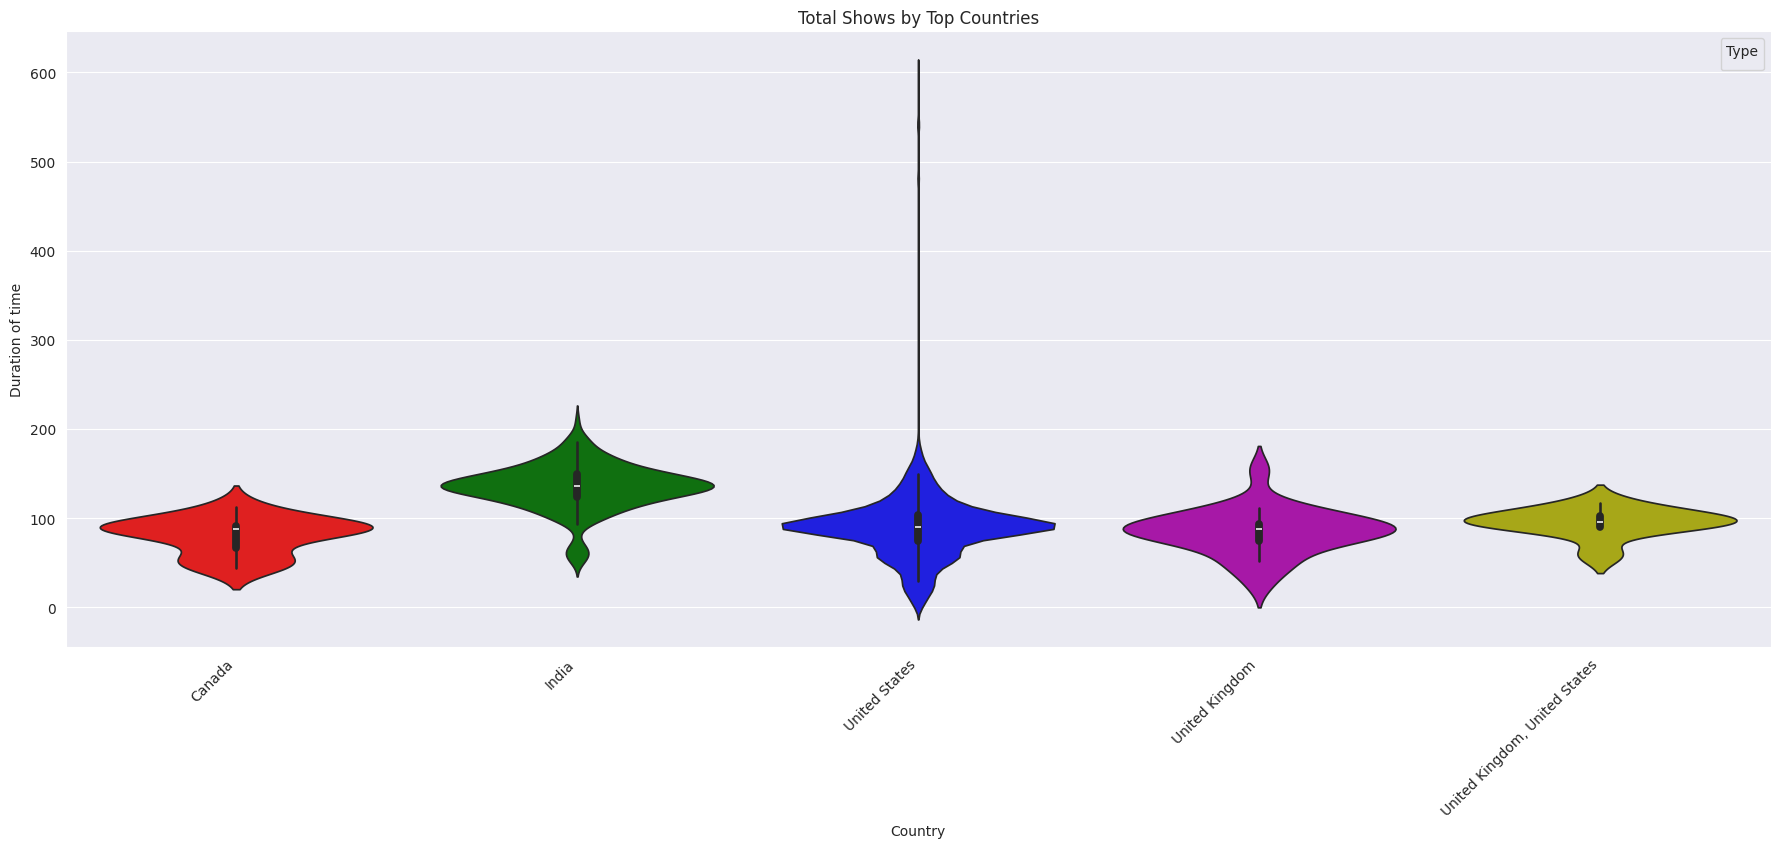

In [121]:
# Visualize the total shows by country for the top countries
# Top N countries
top_countries = df['country'].value_counts().head(5).index

df_movies_top_countries = df_movies[df_movies.country.isin(top_countries)]

plt.figure(figsize=(22, 8))
sns.violinplot(x='country',
               data=df_movies_top_countries,
               y='duration_time',
               hue='country',
               palette=['r','g','b','m', 'y'])
plt.title('Total Shows by Top Countries')
plt.xlabel('Country')
plt.ylabel('Duration of time')
plt.legend(title='Type', loc='upper right')
plt.xticks(rotation=45, ha='right')
plt.show();

# Descriptions Recommendations Exploration
Recommendation systems are usually done via user interest and stats e.g., what movies have they watched, shows liked, minutes watched, genres watched etc. Since we don't have user data in that way, let's develop a basic recommendation system that will return the top 5 movies based off of a user query for what they would like to watch.

In [65]:
# let's look at only movies and their descriptions
df[df.type == 'Movie'].description.values[:7]

array(["A small fishing village must procure a local doctor to secure a lucrative business contract. When unlikely candidate and big city doctor Paul Lewis lands in their lap for a trial residence, the townsfolk rally together to charm him into staying. As the doctor's time in the village winds to a close, acting mayor Murray French has no choice but to pull out all the stops.",
       'A Metro Family decides to fight a Cyber Criminal threatening their stability and pride.',
       'After a man discovers his wife is cheating on him with a neighborhood kid he goes down a furious path of self-destruction',
       'Pink breaks the mold once again, bringing her career to a new level in 2013 with a world tour that entertains unlike ever before! Get inside access to "the girl who got the party started" with exclusive interviews and rare live performances.',
       'Teenage Matt Banting wants to work with a famous but eccentric creature/special effects man named Chancey Bellows. He gets more 

In [66]:
# get the lengths of each of the descriptions and see what those look like
df['description_length'] = df.description.apply(lambda x : len(x.split(' ')))
df.sample(7)


,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,genres,duration_season,description_length
5695,s5696,Movie,Chiriakhana,Satyajit Ray,"Uttam Kumar, Kanika Mozumdar, Shubhendu Chatto...",United States,Unknown,1967,13+,127 min,Drama,"Byomkesh Bakshi, a detective, is hired by a ri...",[Drama],False,42
7842,s7843,TV Show,My Magic Pet Morphle - Songs for Kids,Unknown,Unknown,United States,Unknown,2021,ALL,1 Season,Kids,Morphle can morph into anything his human comp...,[Kids],True,64
7199,s7200,Movie,Maha Maha,Mathivanan Sakthivel,"Mathivanan Sakthivel, Melissa, Indira, Nizhalg...",United States,Unknown,2015,13+,98 min,"Romance, Suspense","Vijay, a windmill engineer, relocates to Austr...","[Romance, Suspense]",False,35
2432,s2433,Movie,Foxtrot Six,Randy Korompis,"Oka Antara, Rio Dewanto, Chicco Jerikho, Mike ...",United States,Unknown,2020,18+,115 min,"Action, Suspense",A former marine and his friends struggle to sa...,"[Action, Suspense]",False,16
3362,s3363,TV Show,Absentia,Unknown,"Stana Katic, Patrick Heusinger, Matt Le Nevez,...",United States,Unknown,2020,18+,3 Seasons,"Action, Drama",Season 3 picks up after the Dramatic events of...,"[Action, Drama]",True,71
3235,s3236,Movie,Anthem of a Teenage Prophet,Robin Hays,"Cameron Monaghan, Peyton List, Juliette Lewis,...",United States,Unknown,2019,Unknown,102 min,"Drama, Young Adult Audience","Based on the award-winning novel, a teenager's...","[Drama, Young Adult Audience]",False,64
4123,s4124,Movie,Real Construction Trucks for Children - Gecko'...,Christian Hughes,Unknown,United States,Unknown,2019,ALL,35 min,Kids,Gecko takes you into the real world to explore...,[Kids],False,38


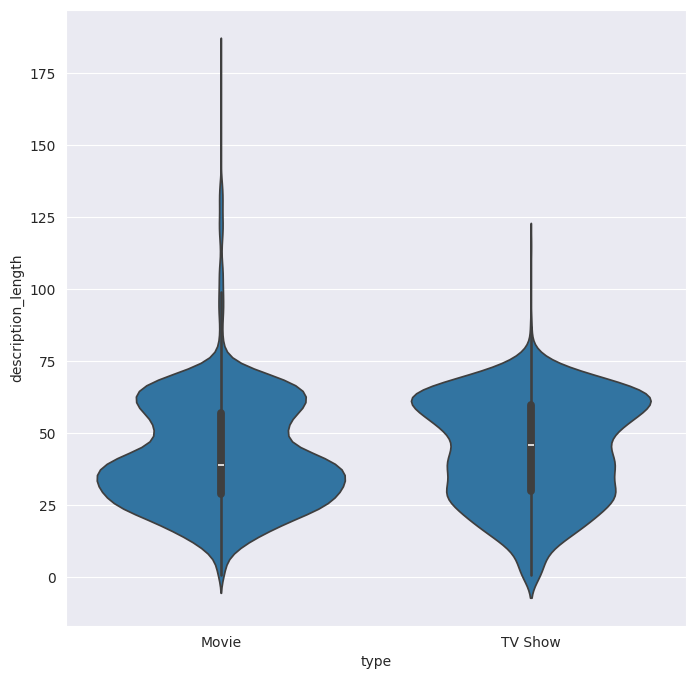

In [67]:
# plot a violin plot of the description lengths
# this will give us an idea of how long each description is
# upon using embeddings
plt.figure(figsize=(8,8))
sns.violinplot(data=df, x='type', y='description_length')
plt.show();

To find general recommendations, we first need to embed the descriptions that we do have into a numerical embedding. Ideally, we'd like for the numerical embeddings to have all the contextual information that describes the film e.g., a drama about sports, comedies about friends etc.

This is going to require us to first embed text into it's numerical representation through the use of LLMs. A powerful technique that does this is the so called Sentence Transformer. Instead of transforming individual words into numerical embeddings, we are going to transform sentences or paragraphs into their numerical embeddings that way we get all of the contextual information needed. More information sentence transformers can be found [here](https://www.sbert.net/).

In [68]:
# import the general use sentence transformer all-mpnet-base-v2
model = SentenceTransformer('all-mpnet-base-v2')

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [69]:
# create a dictionary that will keep
# track of movie titles and descriptions
movie_dict = {
    'movie': df[df.type == 'Movie'].title.values,
    'descriptions' : df[df.type == 'Movie'].description.values
}

In [70]:
# get the movie descriptions into a variable
movie_descriptions = movie_dict['descriptions']

In [71]:
# embed to the descriptions into their
# numerical embeddings
## using a GPU will speed up this process significantly
embeddings = model.encode(movie_dict['descriptions'] , show_progress_bar=True)

Batches:   0%|          | 0/245 [00:00<?, ?it/s]

In [72]:
# get the embeddings shape
embeddings.shape

(7814, 768)

In [73]:
# given a user query, let's embed
# the query into it's numerical representation
user_query = 'a drama about sports'
query_embedding = model.encode(f'{user_query}')

In [75]:
# query_embedding

In [79]:
# another example
# user_query = 'comedies for adults'
user_query = 'movies about world war 2'
query_embedding = model.encode(f'{user_query}')

In [80]:
# get the similarity between the query embedding and
# the movies
similarity_array = cosine_similarity(query_embedding.reshape(1, -1), embeddings)

In [81]:
# get the top 5 movie descriptions that
# are most similar to the query
top_five_sim_indices = np.argsort(-similarity_array)[0][:5].tolist()

In [82]:
# print out the top 5 most
# similar movies to the user query
for idx in top_five_sim_indices:
  print(f"Title: {movie_dict['movie'][idx]}")
  print()
  print(f"Description: {movie_dict['descriptions'][idx]}")
  print('---------------------')

Title: Chosen

Description: Harvey Keitel stars as a Hungarian citizen whose courage alters the course of World War II as he unwittingly becomes a leader and discovers the hero deep within himself.
---------------------
Title: Archive of World War Two - Tunisian Victory

Description: The Archive of World War Two is a series of original archive documentaries filmed under actual battle conditions by service and newsreel cameramen attached to American, British, French, Russian and enemy forces. Contains graphic images of war.
---------------------
Title: Saints and Soldiers: The Void

Description: The German war machine is in retreat. Two American M 18 tank destroyers are sent to root out a die hard group of Nazis holed up in the Harz Mountains
---------------------
Title: Suicide Commandos

Description: Set in World War 2 - a British commando squad is tasked with attacking the "secret" German airfield from which German fighters have been attacking bombers which are trying to stop German 

# Topic Model the Descriptions
Given a large corpus of movies descriptions, can we find out what the movies are about without having to read each one? In other words, can we get a general sense of what types of movies are in the data set just from examining the text?

This is what is known as Topic Modeling and their are a variety of ways to do it, one of the more powerful method is known as BertTopic. For more information on BertTopic please see [here](https://maartengr.github.io/BERTopic/index.html)

In [94]:
# Step 1 - Extract embeddings
embedding_model = SentenceTransformer("all-mpnet-base-v2")

# Step 2 - Reduce dimensionality
umap_model = UMAP(n_neighbors=30, n_components=5, min_dist=0.0, metric='cosine')

# Step 3 - Cluster reduced embeddings
hdbscan_model = HDBSCAN(min_cluster_size=18, metric='euclidean', cluster_selection_method='eom', prediction_data=True)

# Step 4 - Tokenize topics
vectorizer_model = CountVectorizer(stop_words="english")

# Step 5 - Create topic representation
ctfidf_model = ClassTfidfTransformer()

# All steps together
topic_model = BERTopic(
  embedding_model=embedding_model,          # Step 1 - Extract embeddings
  umap_model=umap_model,                    # Step 2 - Reduce dimensionality
  hdbscan_model=hdbscan_model,              # Step 3 - Cluster reduced embeddings
  vectorizer_model=vectorizer_model,        # Step 4 - Tokenize topics
  ctfidf_model=ctfidf_model                # Step 5 - Extract topic words
)


In [95]:
# fit transform the model - this can take some time
# make sure to run it on a GPU if possible
topics, probs = topic_model.fit_transform(movie_descriptions)

In [96]:
# get the general sense of topics
# -1 correspond to outliers and weren't assigned a topic
model_topic_info = topic_model.get_topic_info()
model_topic_info

,Topic,Count,Name,Representation,Representative_Docs
0,-1,3342,-1_life_young_world_new,"[life, young, world, new, story, man, family, ...",[Johnny was a young seminary student who lost ...
1,0,801,0_love_story_life_village,"[love, story, life, village, india, girl, fall...",[A Story of a man who search's for true love a...
2,1,453,1_murder_cop_detective_police,"[murder, cop, detective, police, case, crime, ...",[A passionate traffic police who is bored of h...
3,2,437,2_love_life_relationship_family,"[love, life, relationship, family, friends, mo...","[A teenage couple fall in love, but their rela..."
4,3,378,3_house_haunted_ghost_horror,"[house, haunted, ghost, horror, young, paranor...",[Blake and his mother move into an old mansion...
5,4,286,4_special_comedy_stand_comedian,"[special, comedy, stand, comedian, hour, hilar...",[Emmy nominated writer and comedian Harmony Mc...
6,5,266,5_nursery_songs_kids_little,"[nursery, songs, kids, little, rhymes, baby, c...","[Little Baby Bum is a fun, educational childre..."
7,6,208,6_comedy_star_stars_starring,"[comedy, star, stars, starring, romantic, love...",[SPECIAL EXTENDED EDITION! Get even MORE actio...
8,7,197,7_rock_band_music_album,"[rock, band, music, album, pop, singer, perfor...",['A Night At The Opera' was one of the most ex...
9,8,194,8_gene_roy_autry_gang,"[gene, roy, autry, gang, outlaws, ranch, town,...","[Roy Rogers, the owner of a western ranch, sus..."


In [97]:
# if you want to get a general sense of waht words
# are in each topic
cluster = 3#0, 3, 24
topic_model.get_topic(cluster)

[('house', 0.025619223030244824),
 ('haunted', 0.023846593307816275),
 ('ghost', 0.02160093111631655),
 ('horror', 0.019144806450545577),
 ('young', 0.018028490838866557),
 ('paranormal', 0.015483261957214908),
 ('terrifying', 0.015408037337466244),
 ('group', 0.014096890076425596),
 ('mysterious', 0.013920163911147053),
 ('woman', 0.013650660227181264)]

In [98]:
# see what the outliers look like
model_topic_info[model_topic_info.Topic == -1].Representative_Docs.values[0]

["Johnny was a young seminary student who lost his wife to a drunk driver. With his reason for living gone, John lost his faith and turned to alcohol. Ten years later, John is finally ready to get his life back on track. With his best friend Hickey ('Eric Roberts') in tow John attends his first AA meeting. He finds that his road to recovery tested when he runs into the man who ran down his wife.",
 "A murder-mystery thriller. A world-famous cello player is murdered and crucified in a Seattle Villa that has a reputation for being haunted. His friends and family try to figure out if he was really killed by a supernatural being or if he was assassinated by someone he knows. His dumb and deaf wife and a police detective are pinned against each other as they discover the victim's dark past.",
 "Daring escapes, hilarious stunts and danger turn a Hollywood director's world upside down when he meets a band of street kids living in the slum. Inspired by true events and filled with laughter and 

In [99]:
# look at a sample of the movie descriptions
topic_model.get_document_info(movie_descriptions).sample(7)

,Document,Topic,Name,Representation,Representative_Docs,Top_n_words,Probability,Representative_document
6626,Chandru's grandfather plans to visit him but C...,0,0_love_story_life_village,"[love, story, life, village, india, girl, fall...",[A Story of a man who search's for true love a...,love - story - life - village - india - girl -...,1.000000,False
2734,Join Gecko's Garage and learn more about his c...,5,5_nursery_songs_kids_little,"[nursery, songs, kids, little, rhymes, baby, c...","[Little Baby Bum is a fun, educational childre...",nursery - songs - kids - little - rhymes - bab...,1.000000,False
5732,"After 20 years of roaming, E.F. Bloodworth ret...",-1,-1_life_young_world_new,"[life, young, world, new, story, man, family, ...",[Johnny was a young seminary student who lost ...,life - young - world - new - story - man - fam...,0.000000,False
1265,The story of Kaka Ji highlights the era of the...,0,0_love_story_life_village,"[love, story, life, village, india, girl, fall...",[A Story of a man who search's for true love a...,love - story - life - village - india - girl -...,0.710165,False
5592,"On the eve of their 20th high school reunion, ...",-1,-1_life_young_world_new,"[life, young, world, new, story, man, family, ...",[Johnny was a young seminary student who lost ...,life - young - world - new - story - man - fam...,0.000000,False
5709,A community has mixed feelings over Santa's pe...,19,19_christmas_santa_claus_holiday,"[christmas, santa, claus, holiday, eve, family...",[Elfette has to save the day when Santa Claus ...,christmas - santa - claus - holiday - eve - fa...,1.000000,False
3976,The Lost City of Z tells the incredible true s...,-1,-1_life_young_world_new,"[life, young, world, new, story, man, family, ...",[Johnny was a young seminary student who lost ...,life - young - world - new - story - man - fam...,0.000000,False


In [100]:
# if you would like to visualize the topics you can look at the following three
# plots
topic_model.visualize_topics()

In [101]:
topic_model.visualize_barchart()

In [93]:
topic_model.visualize_heatmap()